# Time Series Forecast

## Import Libraries

In [78]:
import pandas as pd
from datetime import datetime
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

## Download Data

In [2]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [3]:
table[0]

Symbol              Security             GICS Sector  \
0      MMM                    3M             Industrials   
1      AOS           A. O. Smith             Industrials   
2      ABT                Abbott             Health Care   
3     ABBV                AbbVie             Health Care   
4      ACN             Accenture  Information Technology   
..     ...                   ...                     ...   
498    YUM           Yum! Brands  Consumer Discretionary   
499   ZBRA    Zebra Technologies  Information Technology   
500    ZBH         Zimmer Biomet             Health Care   
501   ZION  Zions Bancorporation              Financials   
502    ZTS                Zoetis             Health Care   

                      GICS Sub-Industry    Headquarters Location  Date added  \
0              Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1                     Building Products     Milwaukee, Wisconsin  2017-07-26   
2                 Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                         Biotechnology  North Chicago, Illinois  2012-12-31   
4        IT Consulting & Other Services          Dublin, Ireland  2011-07-06   
..                                  ...                      ...         ...   
498                         Restaurants     Louisville, Kentucky  1997-10-06   
499  Electronic Equipment & Instruments   Lincolnshire, Illinois  2019-12-23   
500               Health Care Equipment          Warsaw, Indiana  2001-08-07   
501                      Regional Banks     Salt Lake City, Utah  2001-06-22   
502                     Pharmaceuticals   Parsippany, New Jersey  2013-06-21   

         CIK      Founded  
0      66740         1902  
1      91142         1916  
2       1800         1888  
3    1551152  2013 (1888)  
4    1467373         1989  
..       ...          ...  
498  1041061         1997  
499   877212         1969  
500  1136869         1927  
501   109380         1873  
502  1555280         1952  

[503 rows x 8 columns]

In [4]:
table[1]

Date  Added                                Removed  \
                  Date Ticker                       Security  Ticker   
0    December 18, 2023   UBER                           Uber     SEE   
1    December 18, 2023    JBL                          Jabil     ALK   
2    December 18, 2023   BLDR           Builders FirstSource    SEDG   
3     October 18, 2023   HUBB                        Hubbell     OGN   
4     October 18, 2023   LULU            Lululemon Athletica    ATVI   
..                 ...    ...                            ...     ...   
332       June 9, 1999    WLP                      Wellpoint     HPH   
333  December 11, 1998    FSR                        Firstar     LDW   
334  December 11, 1998    CCL                 Carnival Corp.     GRN   
335  December 11, 1998   CPWR                      Compuware     SUN   
336      June 17, 1997    CCI  Countrywide Credit Industries     USL   

                               \
                     Security   
0                  Sealed Air   
1            Alaska Air Group   
2                   SolarEdge   
3               Organon & Co.   
4         Activision Blizzard   
..                        ...   
332  Harnischfeger Industries   
333                     Amoco   
334                General Re   
335                SunAmerica   
336                    USLife   

                                                Reason  
                                                Reason  
0                     Market capitalization change.[4]  
1                     Market capitalization change.[4]  
2                     Market capitalization change.[4]  
3                     Market capitalization change.[5]  
4    S&P 500 and S&P 100 constituent Microsoft acqu...  
..                                                 ...  
332           Harnischfeger filed for bankruptcy.[252]  
333                           BP purchased Amoco.[253]  
334      Berkshire Hathaway purchased General Re.[253]  
335                     AIG purchased SunAmerica.[253]  
336                          AIG acquired USLife.[254]  

[337 rows x 6 columns]

In [5]:
new_table = table[0][[datetime.strptime(dt, '%Y-%m-%d') < datetime(2010, 1, 1) for dt in table[0]['Date added']]]

In [6]:
new_table

Symbol              Security             GICS Sector  \
0      MMM                    3M             Industrials   
2      ABT                Abbott             Health Care   
5     ADBE            Adobe Inc.  Information Technology   
7      AES       AES Corporation               Utilities   
8      AFL                 Aflac              Financials   
..     ...                   ...                     ...   
495   WYNN          Wynn Resorts  Consumer Discretionary   
496    XEL           Xcel Energy               Utilities   
498    YUM           Yum! Brands  Consumer Discretionary   
500    ZBH         Zimmer Biomet             Health Care   
501   ZION  Zions Bancorporation              Financials   

                                GICS Sub-Industry    Headquarters Location  \
0                        Industrial Conglomerates    Saint Paul, Minnesota   
2                           Health Care Equipment  North Chicago, Illinois   
5                            Application Software     San Jose, California   
7    Independent Power Producers & Energy Traders      Arlington, Virginia   
8                         Life & Health Insurance        Columbus, Georgia   
..                                            ...                      ...   
495                              Casinos & Gaming         Paradise, Nevada   
496                               Multi-Utilities   Minneapolis, Minnesota   
498                                   Restaurants     Louisville, Kentucky   
500                         Health Care Equipment          Warsaw, Indiana   
501                                Regional Banks     Salt Lake City, Utah   

     Date added      CIK Founded  
0    1957-03-04    66740    1902  
2    1957-03-04     1800    1888  
5    1997-05-05   796343    1982  
7    1998-10-02   874761    1981  
8    1999-05-28     4977    1955  
..          ...      ...     ...  
495  2008-11-14  1174922    2002  
496  1957-03-04    72903    1909  
498  1997-10-06  1041061    1997  
500  2001-08-07  1136869    1927  
501  2001-06-22   109380    1873  

[290 rows x 8 columns]

In [7]:
tickers = new_table['Symbol'].to_numpy()

In [8]:
tickers_ls = list(tickers)

In [9]:
main_tickers = ['AMZN', 'MSFT', 'AAPL', 'GOOGL', 'META']

In [10]:
def check_tickers(main_tickers, tickers_ls):
    not_found_tickers = []

    for ticker in main_tickers:
        if ticker not in tickers_ls:
            print(f'{ticker} not found in your tickers list')
            not_found_tickers.append(ticker)
    
    if not_found_tickers:
        return not_found_tickers
    else:
        print('All main tickers have already existed in tickers list')

In [11]:
not_found_tickers = check_tickers(main_tickers, tickers_ls)

GOOGL not found in your tickers list
META not found in your tickers list


In [12]:
if not_found_tickers:
    tickers_ls.extend(not_found_tickers)

In [13]:
raw_price_for_my_tickers = yf.download(tickers=tickers_ls, start='2010-01-04',
                                       interval='1d', group_by='ticker')

[*********************100%%**********************]  292 of 292 completed


2 Failed downloads:
['BF.B', 'J']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-04 -> 2023-12-24)')


In [14]:
raw_price_for_my_tickers

MSI                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2010-01-04   31.854900   32.420849   31.814474   32.218723   25.717913   
2010-01-05   32.137875   33.391048   31.208099   31.774050   25.362957   
2010-01-06   32.340000   32.501701   31.854900   32.218723   25.717913   
2010-01-07   32.380424   33.108074   32.218723   32.865524   26.234209   
2010-01-08   32.703827   32.825100   31.248526   31.369801   25.040274   
...                ...         ...         ...         ...         ...   
2023-12-18  311.640015  315.040009  311.640015  314.959991  314.959991   
2023-12-19  316.279999  316.309998  311.369995  312.970001  312.970001   
2023-12-20  311.950012  313.709991  308.820007  309.390015  309.390015   
2023-12-21  308.410004  310.950012  307.089996  310.549988  310.549988   
2023-12-22  312.010010  312.410004  308.679993  309.850006  309.850006   

                            TFC                                   ...   J  \
              Volume       Open       High        Low      Close  ... Low   
Date                                                              ...       
2010-01-04   7511713  25.690001  25.870001  25.400000  25.809999  ... NaN   
2010-01-05  18863970  25.709999  26.219999  25.590000  26.180000  ... NaN   
2010-01-06  12137069  25.950001  26.910000  25.950001  26.580000  ... NaN   
2010-01-07  13517526  26.530001  27.959999  26.420000  27.650000  ... NaN   
2010-01-08  18596092  27.520000  27.799999  26.980000  27.340000  ... NaN   
...              ...        ...        ...        ...        ...  ...  ..   
2023-12-18    848600  36.709999  37.049999  36.320000  36.340000  ... NaN   
2023-12-19   1019300  36.410000  36.860001  36.169998  36.720001  ... NaN   
2023-12-20    696700  36.419998  36.849998  35.770000  35.790001  ... NaN   
2023-12-21    484800  36.130001  36.529999  36.110001  36.490002  ... NaN   
2023-12-22    330700  36.669998  36.990002  36.490002  36.759998  ... NaN   

                                         AES                                   \
           Close Adj Close Volume       Open       High        Low      Close   
Date                                                                            
2010-01-04   NaN       NaN    NaN  13.380000  13.700000  13.380000  13.670000   
2010-01-05   NaN       NaN    NaN  13.670000  13.840000  13.500000  13.530000   
2010-01-06   NaN       NaN    NaN  13.450000  13.740000  13.380000  13.390000   
2010-01-07   NaN       NaN    NaN  13.370000  13.580000  13.150000  13.400000   
2010-01-08   NaN       NaN    NaN  13.390000  13.820000  13.350000  13.780000   
...          ...       ...    ...        ...        ...        ...        ...   
2023-12-18   NaN       NaN    NaN  19.430000  19.440001  18.930000  19.020000   
2023-12-19   NaN       NaN    NaN  19.270000  19.500000  19.170000  19.360001   
2023-12-20   NaN       NaN    NaN  19.299999  19.330000  18.350000  18.370001   
2023-12-21   NaN       NaN    NaN  18.600000  19.020000  18.559999  18.850000   
2023-12-22   NaN       NaN    NaN  18.959999  19.320000  18.860001  19.100000   

                                 
            Adj Close    Volume  
Date                             
2010-01-04   9.755467   4597600  
2010-01-05   9.655556   5093200  
2010-01-06   9.555647   7507300  
2010-01-07   9.562784  16843500  
2010-01-08   9.833966   5647500  
...               ...       ...  
2023-12-18  19.020000   4448500  
2023-12-19  19.360001   5259700  
2023-12-20  18.370001   6999800  
2023-12-21  18.850000   4595400  
2023-12-22  19.100000   2907700  

[3518 rows x 1752 columns]

## Preprocessing

### Handling NaN Values

In [15]:
# remove tickers that failed to download
tickers_raw_price = raw_price_for_my_tickers.dropna(axis=1, how='all')

In [16]:
tickers_raw_price

MSI                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2010-01-04   31.854900   32.420849   31.814474   32.218723   25.717913   
2010-01-05   32.137875   33.391048   31.208099   31.774050   25.362957   
2010-01-06   32.340000   32.501701   31.854900   32.218723   25.717913   
2010-01-07   32.380424   33.108074   32.218723   32.865524   26.234209   
2010-01-08   32.703827   32.825100   31.248526   31.369801   25.040274   
...                ...         ...         ...         ...         ...   
2023-12-18  311.640015  315.040009  311.640015  314.959991  314.959991   
2023-12-19  316.279999  316.309998  311.369995  312.970001  312.970001   
2023-12-20  311.950012  313.709991  308.820007  309.390015  309.390015   
2023-12-21  308.410004  310.950012  307.089996  310.549988  310.549988   
2023-12-22  312.010010  312.410004  308.679993  309.850006  309.850006   

                            TFC                                   ...  \
              Volume       Open       High        Low      Close  ...   
Date                                                              ...   
2010-01-04   7511713  25.690001  25.870001  25.400000  25.809999  ...   
2010-01-05  18863970  25.709999  26.219999  25.590000  26.180000  ...   
2010-01-06  12137069  25.950001  26.910000  25.950001  26.580000  ...   
2010-01-07  13517526  26.530001  27.959999  26.420000  27.650000  ...   
2010-01-08  18596092  27.520000  27.799999  26.980000  27.340000  ...   
...              ...        ...        ...        ...        ...  ...   
2023-12-18    848600  36.709999  37.049999  36.320000  36.340000  ...   
2023-12-19   1019300  36.410000  36.860001  36.169998  36.720001  ...   
2023-12-20    696700  36.419998  36.849998  35.770000  35.790001  ...   
2023-12-21    484800  36.130001  36.529999  36.110001  36.490002  ...   
2023-12-22    330700  36.669998  36.990002  36.490002  36.759998  ...   

                   DOV                                         AES             \
                   Low       Close   Adj Close   Volume       Open       High   
Date                                                                            
2010-01-04   27.906073   28.395418   21.572975  1859815  13.380000  13.700000   
2010-01-05   28.120581   28.261351   21.471113  1272199  13.670000  13.840000   
2010-01-06   28.087063   28.596518   21.725752  1852654  13.450000  13.740000   
2010-01-07   28.710476   29.226633   22.204473  1959317  13.370000  13.580000   
2010-01-08   28.971907   30.064552   22.841070  2190843  13.390000  13.820000   
...                ...         ...         ...      ...        ...        ...   
2023-12-18  150.850006  151.800003  151.800003   632300  19.430000  19.440001   
2023-12-19  151.949997  153.300003  153.300003   761700  19.270000  19.500000   
2023-12-20  150.800003  150.979996  150.979996   722000  19.299999  19.330000   
2023-12-21  151.160004  152.479996  152.479996   442100  18.600000  19.020000   
2023-12-22  152.070007  152.940002  152.940002   443500  18.959999  19.320000   

                                                       
                  Low      Close  Adj Close    Volume  
Date                                                   
2010-01-04  13.380000  13.670000   9.755467   4597600  
2010-01-05  13.500000  13.530000   9.655556   5093200  
2010-01-06  13.380000  13.390000   9.555647   7507300  
2010-01-07  13.150000  13.400000   9.562784  16843500  
2010-01-08  13.350000  13.780000   9.833966   5647500  
...               ...        ...        ...       ...  
2023-12-18  18.930000  19.020000  19.020000   4448500  
2023-12-19  19.170000  19.360001  19.360001   5259700  
2023-12-20  18.350000  18.370001  18.370001   6999800  
2023-12-21  18.559999  18.850000  18.850000   4595400  
2023-12-22  18.860001  19.100000  19.100000   2907700  

[3518 rows x 1740 columns]

In [17]:
def print_nan_rows(df, nan_cols):
    nan_rows = df.isnull().sum(axis=0)
    
    for column, nans_count in nan_rows.items():
        if nans_count > 0:
            nan_cols.append(column)
            print(f'{column}: {nans_count} NaN rows')
    
    if len(nan_cols) == 0:
        print('No column with any NaN row found!')

In [18]:
nan_cols = []
print_nan_rows(tickers_raw_price, nan_cols)

('HWM', 'Open'): 1720 NaN rows
('HWM', 'High'): 1720 NaN rows
('HWM', 'Low'): 1720 NaN rows
('HWM', 'Close'): 1720 NaN rows
('HWM', 'Adj Close'): 1720 NaN rows
('HWM', 'Volume'): 1720 NaN rows
('WRK', 'Open'): 1377 NaN rows
('WRK', 'High'): 1377 NaN rows
('WRK', 'Low'): 1377 NaN rows
('WRK', 'Close'): 1377 NaN rows
('WRK', 'Adj Close'): 1377 NaN rows
('WRK', 'Volume'): 1377 NaN rows
('META', 'Open'): 599 NaN rows
('META', 'High'): 599 NaN rows
('META', 'Low'): 599 NaN rows
('META', 'Close'): 599 NaN rows
('META', 'Adj Close'): 599 NaN rows
('META', 'Volume'): 599 NaN rows
('BEN', 'Open'): 1 NaN rows
('BEN', 'High'): 1 NaN rows
('BEN', 'Low'): 1 NaN rows
('BEN', 'Close'): 1 NaN rows
('BEN', 'Adj Close'): 1 NaN rows
('BEN', 'Volume'): 1 NaN rows


In [19]:
def fill_nan_cols(nan_cols, n):
    Q1 = n // 4
    Q3 = n - Q1

    for col in nan_cols:
        first_vaild_ind = tickers_raw_price[col].index.get_loc(tickers_raw_price[col].first_valid_index())
        last_valid_ind = tickers_raw_price[col].index.get_loc(tickers_raw_price[col].last_valid_index())       
        
        if first_vaild_ind != 0:
            tickers_raw_price[col].bfill(inplace=True)
            continue
        
        if last_valid_ind != n - 1:
            tickers_raw_price[col].ffill(inplace=True)
            continue

        if first_vaild_ind <= Q1:
            tickers_raw_price[col].bfill(inplace=True)
        elif Q1 < first_vaild_ind < Q3:
            tickers_raw_price[col].interpolate(inplace=True)
        else:
            tickers_raw_price[col].ffill(inplace=True)

In [20]:
n = tickers_raw_price.shape[0]

In [21]:
fill_nan_cols(nan_cols, n)

In [22]:
print_nan_rows(tickers_raw_price, [])

No column with any NaN row found!


In [23]:
downloaded_tickers = tickers_raw_price.columns.get_level_values(0).unique().to_list()

In [24]:
# to verify all main tickers downloaded or not
check_tickers(main_tickers, downloaded_tickers)

All main tickers have already existed in tickers list


### Plot Close Price Return Histogram

In [25]:
random_ticker = np.random.choice(downloaded_tickers)

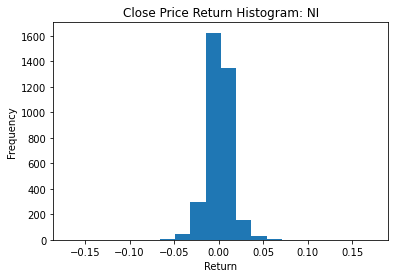

In [26]:
returns = tickers_raw_price[(random_ticker, 'Close')].pct_change()

plt.hist(returns.dropna(), bins=20)
plt.title(f'Close Price Return Histogram: {random_ticker}')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

### Plot Candle Stick

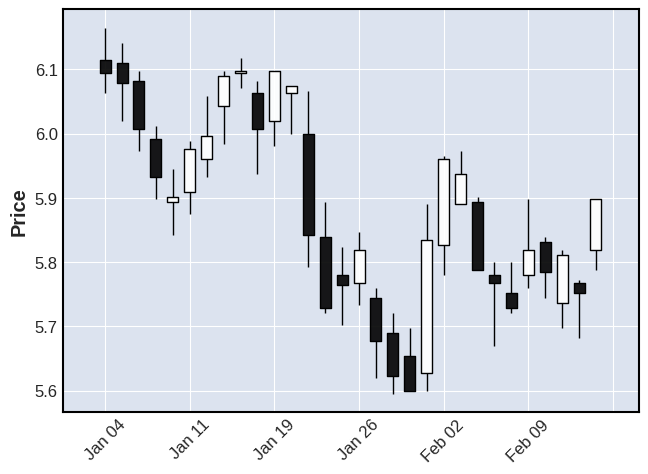

In [27]:
df = tickers_raw_price[random_ticker]
df.index = pd.to_datetime(df.index)


mpf.plot(df.iloc[:30], type='candle')

### Cross Validation

In [28]:
sub_columns = tickers_raw_price.columns.get_level_values(1).unique().to_list()

columns_to_filter = [(ticker, sub_column) for ticker in main_tickers for sub_column in sub_columns]

main_data = tickers_raw_price.loc[:, columns_to_filter]

main_data

AMZN                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2010-01-04    6.812500    6.830500    6.657000    6.695000    6.695000   
2010-01-05    6.671500    6.774000    6.590500    6.734500    6.734500   
2010-01-06    6.730000    6.736500    6.582500    6.612500    6.612500   
2010-01-07    6.600500    6.616000    6.440000    6.500000    6.500000   
2010-01-08    6.528000    6.684000    6.451500    6.676000    6.676000   
...                ...         ...         ...         ...         ...   
2023-12-18  150.559998  154.850006  150.050003  154.070007  154.070007   
2023-12-19  154.399994  155.119995  152.690002  153.789993  153.789993   
2023-12-20  152.899994  155.630005  151.559998  152.119995  152.119995   
2023-12-21  153.300003  153.970001  152.100006  153.839996  153.839996   
2023-12-22  153.770004  154.350006  152.710007  153.419998  153.419998   

                             MSFT                                      ...  \
               Volume        Open        High         Low       Close  ...   
Date                                                                   ...   
2010-01-04  151998000   30.620001   31.100000   30.590000   30.950001  ...   
2010-01-05  177038000   30.850000   31.100000   30.639999   30.959999  ...   
2010-01-06  143576000   30.879999   31.080000   30.520000   30.770000  ...   
2010-01-07  220604000   30.629999   30.700001   30.190001   30.450001  ...   
2010-01-08  196610000   30.280001   30.879999   30.240000   30.660000  ...   
...               ...         ...         ...         ...         ...  ...   
2023-12-18   62512800  369.450012  373.000000  368.679993  372.649994  ...   
2023-12-19   43171300  371.489990  373.260010  369.839996  373.260010  ...   
2023-12-20   50322100  375.000000  376.029999  370.529999  370.619995  ...   
2023-12-21   36305700  372.559998  374.410004  370.040009  373.540009  ...   
2023-12-22   29480100  373.679993  375.179993  372.709991  374.579987  ...   

                 GOOGL                                           META  \
                   Low       Close   Adj Close     Volume        Open   
Date                                                                    
2010-01-04   15.621622   15.684434   15.684434   78169752   42.049999   
2010-01-05   15.554054   15.615365   15.615365  120067812   42.049999   
2010-01-06   15.174174   15.221722   15.221722  158988852   42.049999   
2010-01-07   14.831081   14.867367   14.867367  256315428   42.049999   
2010-01-08   14.742492   15.065566   15.065566  188783028   42.049999   
...                ...         ...         ...        ...         ...   
2023-12-18  132.429993  135.800003  135.800003   32258000  337.480011   
2023-12-19  136.080002  136.649994  136.649994   25476800  345.579987   
2023-12-20  138.070007  138.339996  138.339996   49107200  348.649994   
2023-12-21  139.179993  140.419998  140.419998   27488300  352.980011   
2023-12-22  140.710007  141.490005  141.490005   26514600  355.579987   

                                                                         
                  High         Low       Close   Adj Close       Volume  
Date                                                                     
2010-01-04   45.000000   38.000000   38.230000   38.230000  573576400.0  
2010-01-05   45.000000   38.000000   38.230000   38.230000  573576400.0  
2010-01-06   45.000000   38.000000   38.230000   38.230000  573576400.0  
2010-01-07   45.000000   38.000000   38.230000   38.230000  573576400.0  
2010-01-08   45.000000   38.000000   38.230000   38.230000  573576400.0  
...                ...         ...         ...         ...          ...  
2023-12-18  347.559998  337.019989  344.619995  344.619995   18993900.0  
2023-12-19  353.600006  345.119995  350.359985  350.359985   17729400.0  
2023-12-20  354.959991  347.790009  349.279999  349

In [29]:
columns_to_filter = [(ticker, 'Close') for ticker in main_tickers]

close_price = main_data.loc[:, columns_to_filter]

In [30]:
close_price

AMZN        MSFT        AAPL       GOOGL        META
                 Close       Close       Close       Close       Close
Date                                                                  
2010-01-04    6.695000   30.950001    7.643214   15.684434   38.230000
2010-01-05    6.734500   30.959999    7.656429   15.615365   38.230000
2010-01-06    6.612500   30.770000    7.534643   15.221722   38.230000
2010-01-07    6.500000   30.450001    7.520714   14.867367   38.230000
2010-01-08    6.676000   30.660000    7.570714   15.065566   38.230000
...                ...         ...         ...         ...         ...
2023-12-18  154.070007  372.649994  195.889999  135.800003  344.619995
2023-12-19  153.789993  373.260010  196.940002  136.649994  350.359985
2023-12-20  152.119995  370.619995  194.830002  138.339996  349.279999
2023-12-21  153.839996  373.540009  194.679993  140.419998  354.089996
2023-12-22  153.419998  374.579987  193.600006  141.490005  353.390015

[3518 rows x 5 columns]

In [31]:
tickers_ind2name = {}

for i in range(len(main_tickers)):
    tickers_ind2name[i] = main_tickers[i]

In [32]:
tickers_ind2name

{0: 'AMZN', 1: 'MSFT', 2: 'AAPL', 3: 'GOOGL', 4: 'META'}

In [33]:
close_price.describe()

AMZN         MSFT         AAPL        GOOGL         META
             Close        Close        Close        Close        Close
count  3518.000000  3518.000000  3518.000000  3518.000000  3518.000000
mean     63.244549   114.998619    59.774832    54.005494   137.127140
std      54.714693   101.517382    55.293809    39.019137    93.976387
min       5.430500    23.010000     6.858929    10.912663    17.730000
25%      14.092250    33.012499    19.607946    21.926427    38.230000
50%      40.883499    62.615000    32.271250    40.945499   124.809998
75%      99.675373   200.377499    90.881872    73.449499   190.052505
max     186.570496   382.700012   198.110001   149.838501   382.179993

In [34]:
scaler = MinMaxScaler()

scaled_close_price = pd.DataFrame(scaler.fit_transform(close_price), columns=close_price.columns,
                                      index=close_price.index)
scaled_close_price

AMZN      MSFT      AAPL     GOOGL      META
               Close     Close     Close     Close     Close
Date                                                        
2010-01-04  0.006981  0.022075  0.004101  0.034348  0.056249
2010-01-05  0.007199  0.022102  0.004170  0.033850  0.056249
2010-01-06  0.006525  0.021574  0.003533  0.031017  0.056249
2010-01-07  0.005904  0.020684  0.003460  0.028466  0.056249
2010-01-08  0.006876  0.021268  0.003722  0.029893  0.056249
...              ...       ...       ...       ...       ...
2023-12-18  0.820578  0.972059  0.988392  0.898950  0.896941
2023-12-19  0.819032  0.973755  0.993882  0.905068  0.912690
2023-12-20  0.809813  0.966415  0.982850  0.917233  0.909727
2023-12-21  0.819308  0.974534  0.982065  0.932205  0.922925
2023-12-22  0.816990  0.977425  0.976418  0.939907  0.921004

[3518 rows x 5 columns]

In [35]:
scaled_close_price.describe()

AMZN         MSFT         AAPL        GOOGL         META
             Close        Close        Close        Close        Close
count  3518.000000  3518.000000  3518.000000  3518.000000  3518.000000
mean      0.319168     0.255744     0.276683     0.310186     0.327609
std       0.302057     0.282236     0.289116     0.280863     0.257858
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       0.047818     0.027809     0.066661     0.079278     0.056249
50%       0.195722     0.110109     0.132874     0.216179     0.293813
75%       0.520287     0.493112     0.439333     0.450145     0.472829
max       1.000000     1.000000     1.000000     1.000000     1.000000

In [36]:
def create_x_y_ls(data, window_size):

    X_data, y_data = [], []

    for col_ind, col_name in enumerate(data):
        X, y = [], []
        for i in range(window_size, len(data[col_name])):
            X.append(data[col_name][i - window_size:i])
            y.append(data[col_name][i])
        
        X = np.array(X)
        y = np.array(y)
        
        X_data.append(X[(31 - window_size):])
        y_data.append(y[(31 - window_size):])
    
    return X_data, y_data

In [37]:
window_size = 10

In [38]:
X_ls, y_ls = create_x_y_ls(close_price, window_size)
X_scaled_ls, y_scaled_ls = create_x_y_ls(scaled_close_price, window_size)

/tmp/ipykernel_7083/3285722781.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[col_name][i])


In [39]:
X = np.array(X_ls)
y = np.array(y_ls)

X_scaled = np.array(X_scaled_ls)
y_scaled = np.array(y_scaled_ls)

In [40]:
X.shape, X_scaled.shape, y.shape, y_scaled.shape

((5, 3487, 10), (5, 3487, 10), (5, 3487), (5, 3487))

In [41]:
def ts_train_test_split(X, y, n_splits):
    tss = TimeSeriesSplit(n_splits=n_splits)
    train_test = {}

    for ticker_ind in range(X.shape[0]):
        full_X = X[ticker_ind]
        full_y = y[ticker_ind]
        
        ticker_name = tickers_ind2name[ticker_ind]
        
        train_test[ticker_name] = {}

        for train_ind, test_ind in tss.split(full_X):
            train_X, test_X = full_X[train_ind], full_X[test_ind]
            train_y, test_y = full_y[train_ind], full_y[test_ind]

            train_test[ticker_name]['X_train'] = train_X
            train_test[ticker_name]['X_test'] = test_X
            train_test[ticker_name]['y_train'] = train_y
            train_test[ticker_name]['y_test'] = test_y

    return train_test

In [42]:
train_test = ts_train_test_split(X, y, 5)

In [43]:
train_test_scaled = ts_train_test_split(X_scaled, y_scaled, 5)

In [44]:
train_test['AMZN']['X_train'].shape, train_test_scaled['AMZN']['X_train'].shape

((2906, 10), (2906, 10))

## Models

### Hyperparameters

In [45]:
n_epochs = 20
learning_rate = 0.001

### Utils

In [46]:
def plot_metrics(history, ticker_name):
    plt.figure(figsize=(18, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['mae'], label=f'Training MAE for ' + ticker_name)
    plt.plot(history.history['val_mae'], label=f'Validation MAE for ' + ticker_name)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.grid()
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['mse'], label='Training MSE for ' + ticker_name)
    plt.plot(history.history['val_mse'], label='Validation MSE for ' + ticker_name)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid()
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['mape'], label='Training MAPE for ' + ticker_name)
    plt.plot(history.history['val_mape'], label='Validation MAPE for ' + ticker_name)
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.grid()
    plt.legend()

    plt.show()

In [47]:
def fit_predict(model, train_test_data, main_tickers, n_epochs):
    for i in range(len(main_tickers)):
        ticker_name = tickers_ind2name[i]

        history = model.fit(train_test_data[ticker_name]['X_train'], train_test_data[ticker_name]['y_train'],
                            validation_data=(train_test_data[ticker_name]['X_test'],
                                             train_test_data[ticker_name]['y_test']),
                            epochs=n_epochs)
        
        plot_metrics(history, ticker_name)

### LSTM

In [48]:
lstm_model = Sequential([layers.Input((window_size, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(1)])

lstm_model.compile(loss='mse', 
              optimizer=Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae'),
                       tf.keras.metrics.MeanSquaredError(name='mse'),
                       tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])

lstm_model.summary()

2023-12-24 14:25:00.149244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-24 14:25:00.394234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-24 14:25:00.394423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20065 (78.38 KB)
Trainable params: 20065 (

Epoch 1/20


2023-12-24 14:25:02.306661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-24 14:25:03.258866: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4034291360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-24 14:25:03.258907: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-12-24 14:25:03.267051: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-24 14:25:03.355621: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 [==============================] - 3s 6ms/step - loss: 3829.5530 - mae: 41.7942 - mse: 3829.5530 - mape: 86.0686 - val_loss: 5669.2891 - val_mae: 70.6746 - val_mse: 5669.2891 - val_mape: 52.2888
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 476.4232 - mae: 12.0612 - mse: 476.4232 - mape: 26.7449 - val_loss: 154.2960 - val_mae: 8.9718 - val_mse: 154.2960 - val_mape: 6.3617
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 200.4931 - mae: 8.1770 - mse: 200.4931 - mape: 16.9218 - val_loss: 46.2674 - val_mae: 5.2973 - val_mse: 46.2674 - val_mape: 4.0670
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 183.9091 - mae: 7.7601 - mse: 183.9091 - mape: 16.2682 - val_loss: 156.7689 - val_mae: 10.3293 - val_mse: 156.7689 - val_mape: 8.0806
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 153.7186 - mae: 7.2928 - mse: 153.7186 - mape: 15.6147 - val_loss: 37.1048 - val_mae: 4.8185 - val_mse: 37.1048 

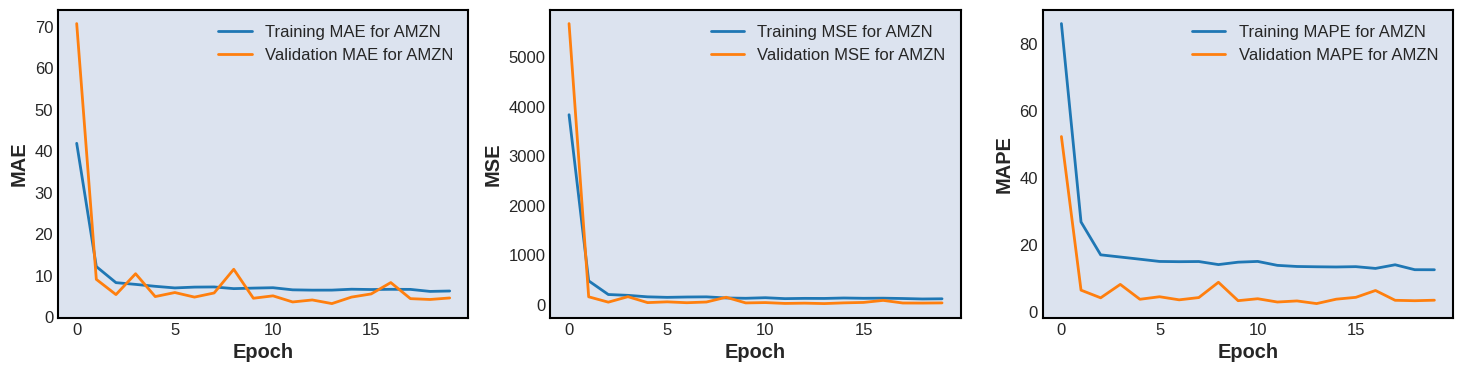

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 297.3778 - mae: 10.2824 - mse: 297.3778 - mape: 12.7826 - val_loss: 2397.3550 - val_mae: 39.5320 - val_mse: 2397.3550 - val_mape: 12.3724
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 282.7245 - mae: 10.4691 - mse: 282.7245 - mape: 13.2162 - val_loss: 1267.8329 - val_mae: 26.7001 - val_mse: 1267.8329 - val_mape: 8.2781
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 288.6671 - mae: 10.6536 - mse: 288.6671 - mape: 13.4465 - val_loss: 2073.5374 - val_mae: 39.1326 - val_mse: 2073.5374 - val_mape: 12.5107
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 271.3567 - mae: 10.0783 - mse: 271.3567 - mape: 12.6865 - val_loss: 1499.0684 - val_mae: 30.5117 - val_mse: 1499.0684 - val_mape: 9.5109
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 267.2429 - mae: 10.4681 - mse: 267.2429 - mape: 13.4915 - val_loss: 2702.7400 - val_mae: 4

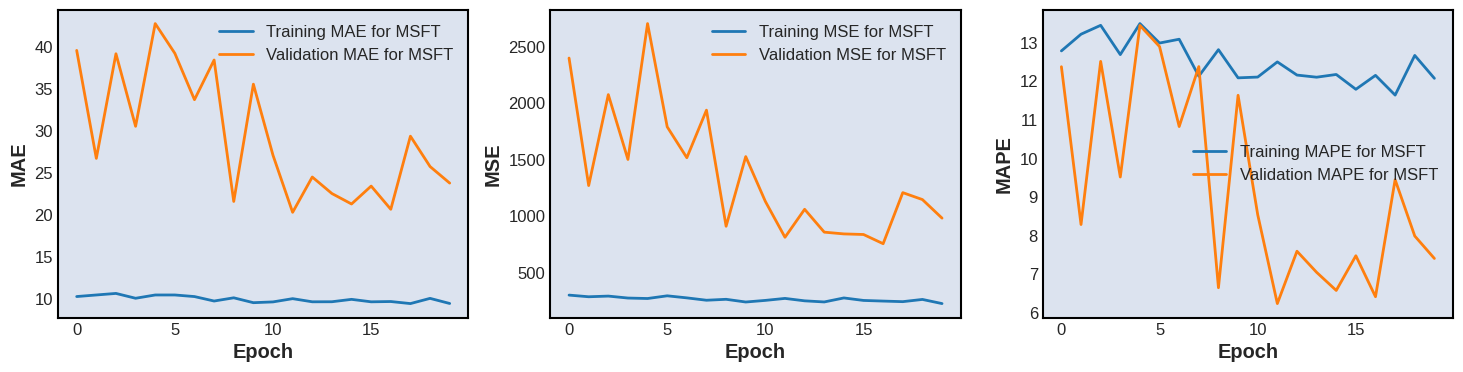

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 52.7139 - mae: 4.4307 - mse: 52.7139 - mape: 10.9572 - val_loss: 109.4727 - val_mae: 9.7308 - val_mse: 109.4727 - val_mape: 5.9388
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 57.9495 - mae: 4.5606 - mse: 57.9495 - mape: 11.1533 - val_loss: 18.0777 - val_mae: 3.3608 - val_mse: 18.0777 - val_mape: 2.0497
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 54.7705 - mae: 4.4242 - mse: 54.7705 - mape: 10.6952 - val_loss: 76.5908 - val_mae: 8.0777 - val_mse: 76.5908 - val_mape: 5.0947
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 58.1300 - mae: 4.4601 - mse: 58.1300 - mape: 10.7121 - val_loss: 31.1645 - val_mae: 4.7371 - val_mse: 31.1645 - val_mape: 3.0031
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 54.1655 - mae: 4.4477 - mse: 54.1655 - mape: 10.9551 - val_loss: 16.9997 - val_mae: 3.2082 - val_mse: 16.9997 - val_mape: 

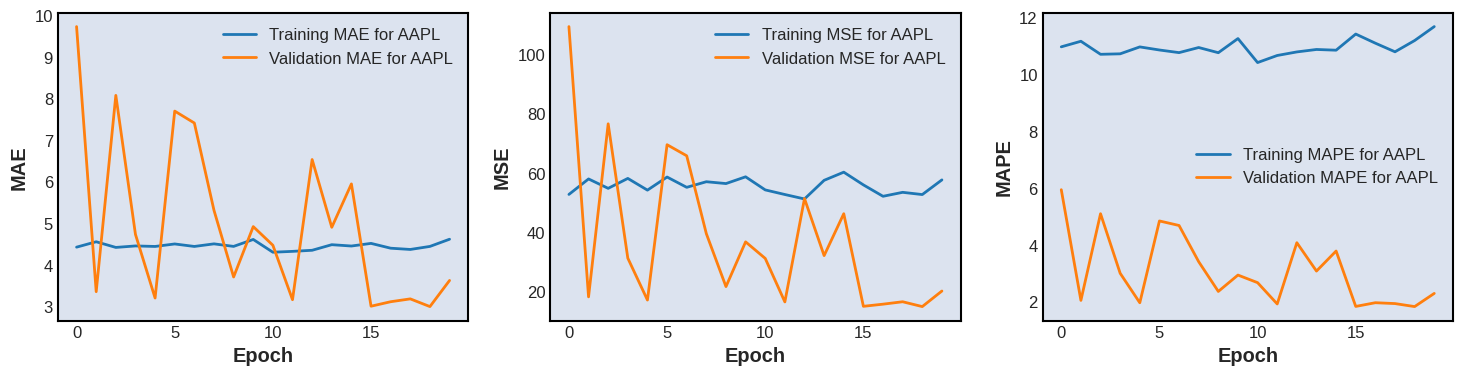

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 43.8766 - mae: 4.3496 - mse: 43.8766 - mape: 10.1357 - val_loss: 7.3455 - val_mae: 2.0720 - val_mse: 7.3455 - val_mape: 1.7590
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 45.1889 - mae: 4.4104 - mse: 45.1889 - mape: 10.2771 - val_loss: 22.0012 - val_mae: 4.0354 - val_mse: 22.0012 - val_mape: 3.4866
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 49.7987 - mae: 4.5743 - mse: 49.7987 - mape: 10.6253 - val_loss: 10.0200 - val_mae: 2.5348 - val_mse: 10.0200 - val_mape: 2.0932
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 46.4703 - mae: 4.4224 - mse: 46.4703 - mape: 10.2309 - val_loss: 12.3228 - val_mae: 2.8338 - val_mse: 12.3228 - val_mape: 2.3578
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 51.6093 - mae: 4.6602 - mse: 51.6093 - mape: 10.6183 - val_loss: 29.9793 - val_mae: 4.9094 - val_mse: 29.9793 - val_mape: 4.10

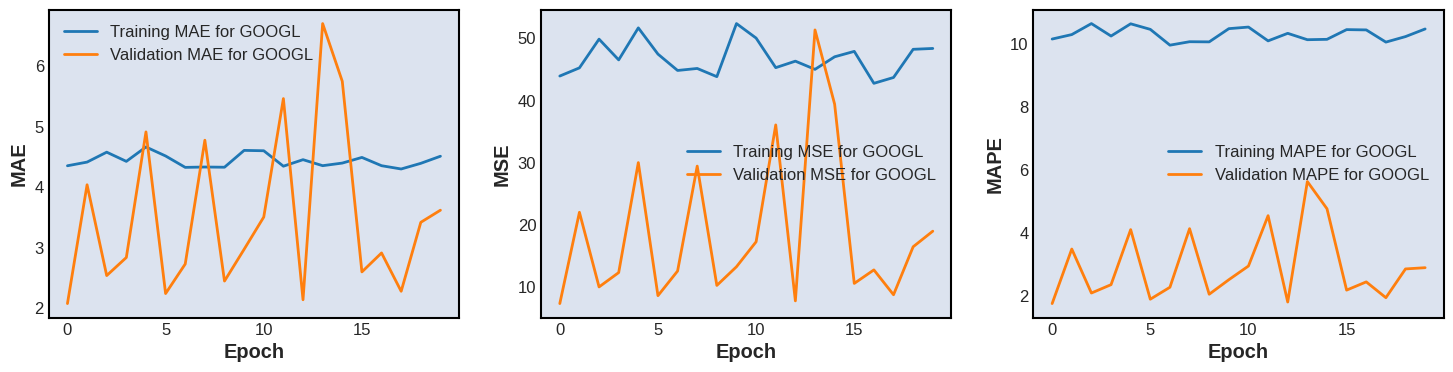

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 562.9033 - mae: 14.9577 - mse: 562.9033 - mape: 12.1747 - val_loss: 170.3380 - val_mae: 10.1095 - val_mse: 170.3380 - val_mape: 4.6525
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 509.6465 - mae: 14.2452 - mse: 509.6465 - mape: 11.3962 - val_loss: 175.3278 - val_mae: 9.9002 - val_mse: 175.3278 - val_mape: 4.0017
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 477.3932 - mae: 14.2232 - mse: 477.3932 - mape: 11.5446 - val_loss: 256.1249 - val_mae: 12.4580 - val_mse: 256.1249 - val_mape: 4.7738
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 469.3820 - mae: 14.0408 - mse: 469.3820 - mape: 11.3087 - val_loss: 103.5031 - val_mae: 7.5396 - val_mse: 103.5031 - val_mape: 3.5331
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 487.9255 - mae: 14.3831 - mse: 487.9255 - mape: 11.8531 - val_loss: 164.1367 - val_mae: 10.1878 - val_

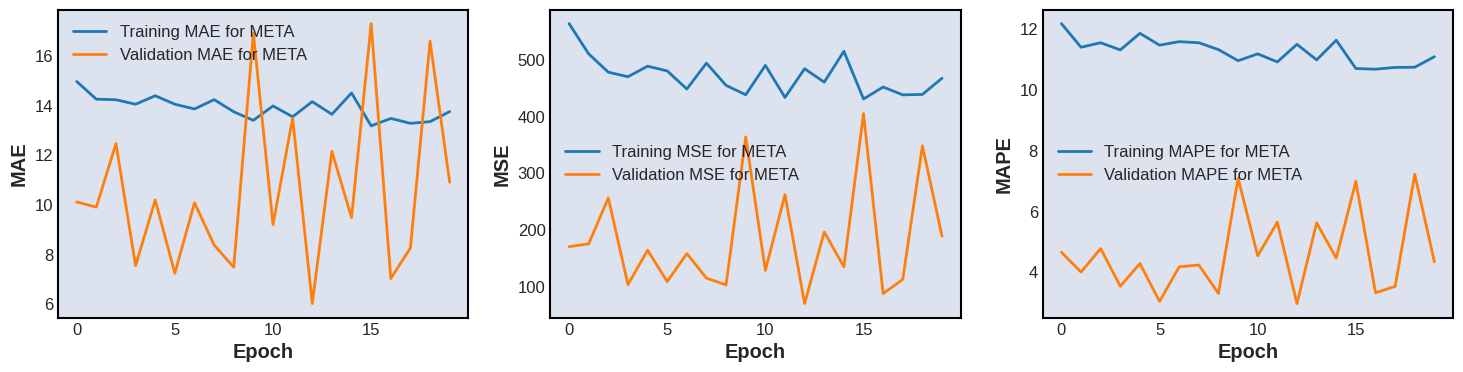

In [49]:
fit_predict(lstm_model, train_test, main_tickers, n_epochs)

Epoch 1/20
 1/91 [..............................] - ETA: 0s - loss: 490.4525 - mae: 22.0389 - mse: 490.4525 - mape: 49726.8750

91/91 [==============================] - 0s 4ms/step - loss: 75.4053 - mae: 5.5334 - mse: 75.4053 - mape: 1250995.3750 - val_loss: 0.0447 - val_mae: 0.1778 - val_mse: 0.0447 - val_mape: 30.6248
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 3.4453 - mae: 1.3610 - mse: 3.4453 - mape: 383681.4062 - val_loss: 0.2083 - val_mae: 0.4364 - val_mse: 0.2083 - val_mape: 70.5113
Epoch 3/20
91/91 [==============================] - 0s 4ms/step - loss: 1.7342 - mae: 0.8592 - mse: 1.7342 - mape: 104381.6016 - val_loss: 0.0641 - val_mae: 0.2181 - val_mse: 0.0641 - val_mape: 37.2370
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 1.0409 - mae: 0.7204 - mse: 1.0409 - mape: 445777.2812 - val_loss: 0.0840 - val_mae: 0.2606 - val_mse: 0.0840 - val_mape: 43.6118
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.9040 - mae: 0.6700 - mse: 0.9040 - mape: 456557.7188 - val_loss: 0.0490 - val_mae: 0.1889 - val_mse: 0.0490 - val_mape: 32.375

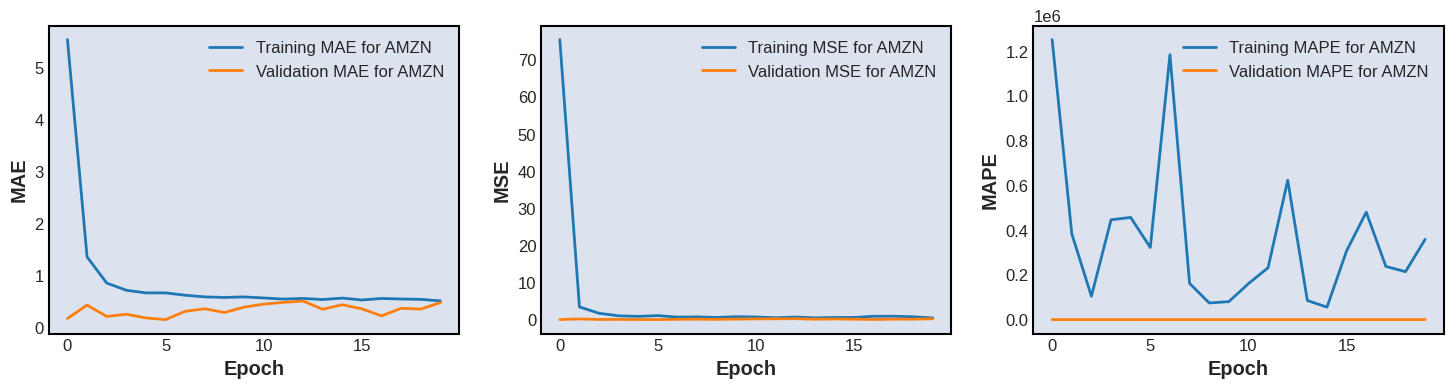

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.5818 - mae: 0.5230 - mse: 0.5818 - mape: 137816.7188 - val_loss: 0.1433 - val_mae: 0.3699 - val_mse: 0.1433 - val_mape: 51.5942
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.4525 - mae: 0.5124 - mse: 0.4525 - mape: 167337.5312 - val_loss: 0.1778 - val_mae: 0.4135 - val_mse: 0.1778 - val_mape: 57.5353
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.7411 - mae: 0.5184 - mse: 0.7411 - mape: 174220.5156 - val_loss: 0.1169 - val_mae: 0.3354 - val_mse: 0.1169 - val_mape: 46.6122
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.4267 - mae: 0.5070 - mse: 0.4267 - mape: 129258.2969 - val_loss: 0.1898 - val_mae: 0.4281 - val_mse: 0.1898 - val_mape: 59.4759
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.5620 - mae: 0.4975 - mse: 0.5620 - mape: 89818.9531 - val_loss: 0.1623 - val_mae: 0.3945 - val_mse: 0.1623 - val_mape:

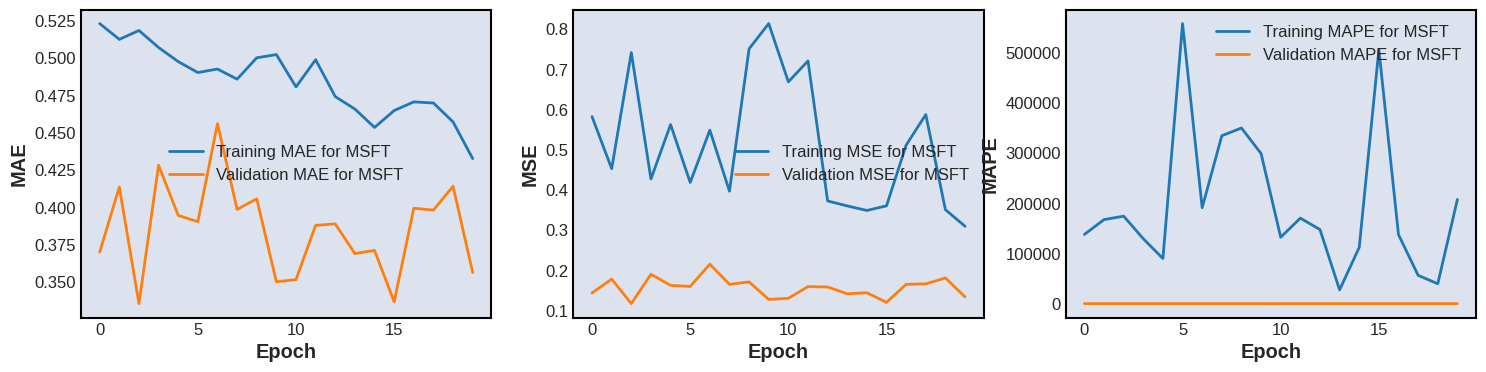

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.4920 - mae: 0.4612 - mse: 0.4920 - mape: 826.7227 - val_loss: 0.1390 - val_mae: 0.3659 - val_mse: 0.1390 - val_mape: 46.5351
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3021 - mae: 0.4312 - mse: 0.3021 - mape: 795.1566 - val_loss: 0.1179 - val_mae: 0.3350 - val_mse: 0.1179 - val_mape: 42.7417
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.4641 - mae: 0.4431 - mse: 0.4641 - mape: 891.7804 - val_loss: 0.1427 - val_mae: 0.3699 - val_mse: 0.1427 - val_mape: 47.1071
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2891 - mae: 0.4195 - mse: 0.2891 - mape: 755.2441 - val_loss: 0.0998 - val_mae: 0.3074 - val_mse: 0.0998 - val_mape: 39.2747
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.5118 - mae: 0.4439 - mse: 0.5118 - mape: 802.1885 - val_loss: 0.1179 - val_mae: 0.3342 - val_mse: 0.1179 - val_mape: 42.6954
Epoch

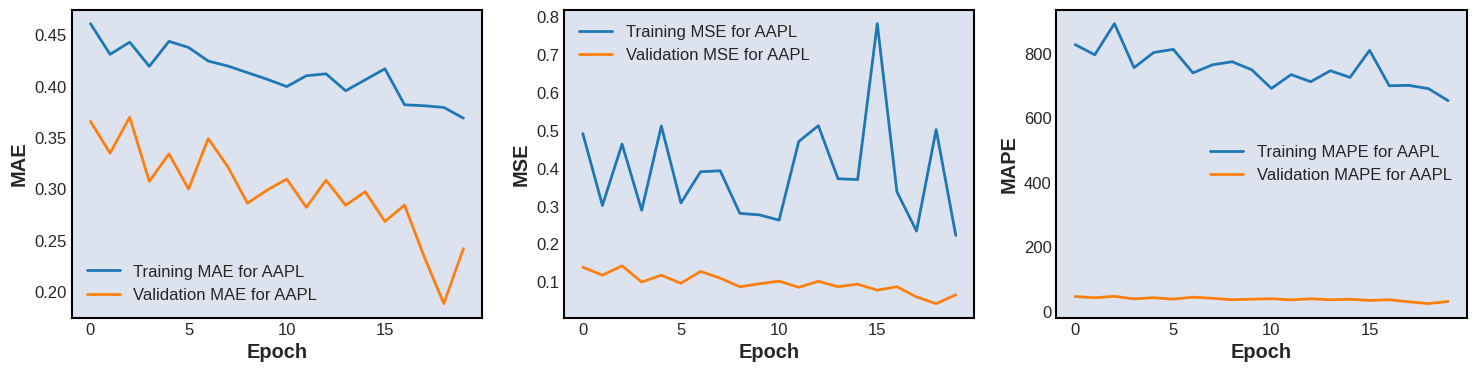

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.5760 - mae: 0.3782 - mse: 0.5760 - mape: 439009.8750 - val_loss: 0.0541 - val_mae: 0.1999 - val_mse: 0.0541 - val_mape: 28.7265
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3343 - mae: 0.3540 - mse: 0.3343 - mape: 637654.7500 - val_loss: 0.1017 - val_mae: 0.2958 - val_mse: 0.1017 - val_mape: 41.2475
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.4262 - mae: 0.3613 - mse: 0.4262 - mape: 202378.4219 - val_loss: 0.0355 - val_mae: 0.1630 - val_mse: 0.0355 - val_mape: 23.3351
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1876 - mae: 0.3404 - mse: 0.1876 - mape: 148795.1562 - val_loss: 0.0715 - val_mae: 0.2432 - val_mse: 0.0715 - val_mape: 34.2085
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3850 - mae: 0.3511 - mse: 0.3850 - mape: 46040.4805 - val_loss: 0.0591 - val_mae: 0.2152 - val_mse: 0.0591 - val_mape:

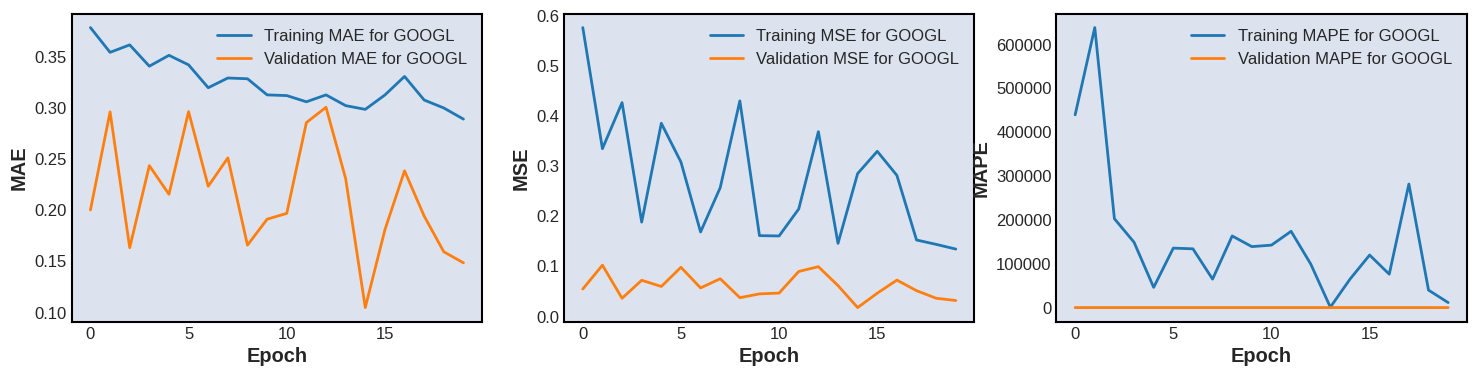

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2157 - mae: 0.2928 - mse: 0.2157 - mape: 454079.0312 - val_loss: 0.0281 - val_mae: 0.1505 - val_mse: 0.0281 - val_mape: 31.8266
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1950 - mae: 0.2714 - mse: 0.1950 - mape: 17007.7832 - val_loss: 0.0379 - val_mae: 0.1616 - val_mse: 0.0379 - val_mape: 39.5685
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1156 - mae: 0.2665 - mse: 0.1156 - mape: 61010.8359 - val_loss: 0.0282 - val_mae: 0.1398 - val_mse: 0.0282 - val_mape: 33.6671
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1993 - mae: 0.2580 - mse: 0.1993 - mape: 200436.5469 - val_loss: 0.0404 - val_mae: 0.1672 - val_mse: 0.0404 - val_mape: 40.3097
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1050 - mae: 0.2509 - mse: 0.1050 - mape: 373697.4062 - val_loss: 0.0284 - val_mae: 0.1516 - val_mse: 0.0284 - val_mape: 

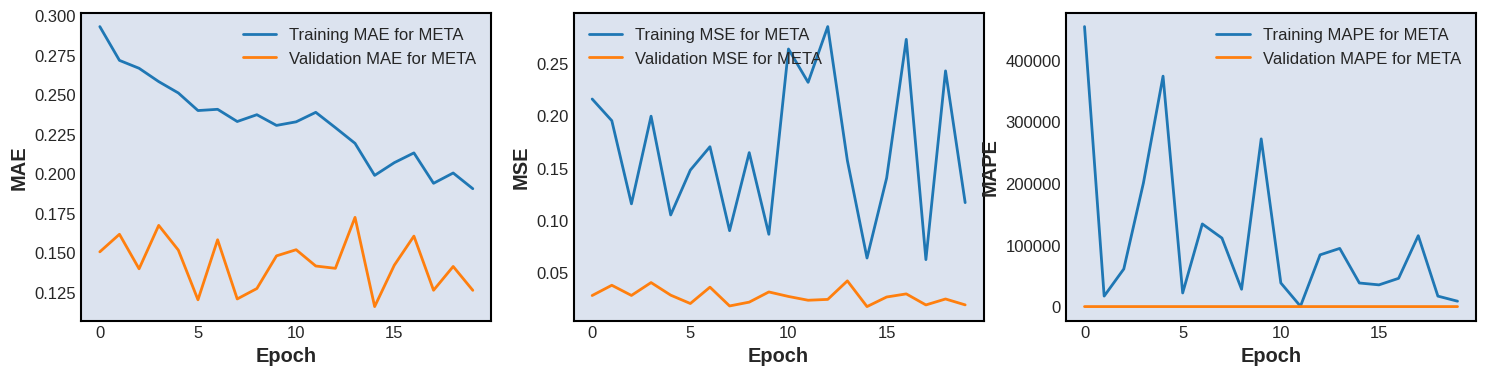

In [50]:
fit_predict(lstm_model, train_test_scaled, main_tickers, n_epochs)

### GRU

In [51]:
gru_model = Sequential([layers.Input((window_size, 1)),
                    layers.GRU(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(1)])

gru_model.compile(loss='mse', 
              optimizer=Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae'),
                       tf.keras.metrics.MeanSquaredError(name='mse'),
                       tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16033 (62.63 KB)
Trainable params: 16033

Epoch 1/20


91/91 [==============================] - 2s 5ms/step - loss: 3259.9829 - mae: 35.7174 - mse: 3259.9829 - mape: 59.0168 - val_loss: 4002.3499 - val_mae: 57.5199 - val_mse: 4002.3499 - val_mape: 41.7085
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 399.1641 - mae: 10.4405 - mse: 399.1641 - mape: 19.1839 - val_loss: 77.4486 - val_mae: 6.9289 - val_mse: 77.4486 - val_mape: 4.9992
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 189.1063 - mae: 7.8880 - mse: 189.1063 - mape: 16.0170 - val_loss: 53.6660 - val_mae: 6.4624 - val_mse: 53.6660 - val_mape: 5.2807
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 182.1402 - mae: 7.8292 - mse: 182.1402 - mape: 15.7773 - val_loss: 31.7692 - val_mae: 4.4442 - val_mse: 31.7692 - val_mape: 3.4031
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 169.1724 - mae: 7.5525 - mse: 169.1724 - mape: 15.7145 - val_loss: 109.5330 - val_mae: 9.7698 - val_mse: 109.5330 - v

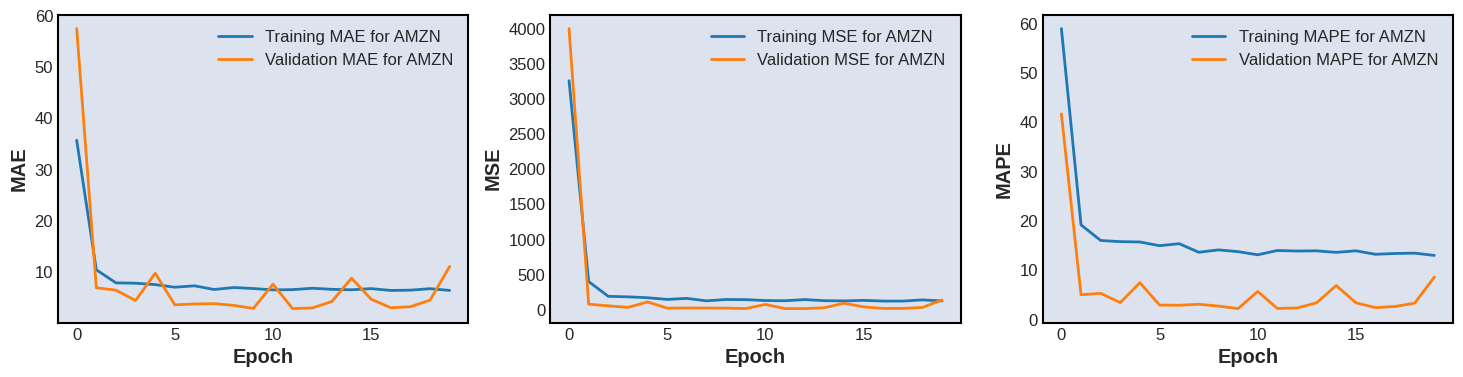

Epoch 1/20
91/91 [==============================] - 0s 5ms/step - loss: 346.2538 - mae: 11.2109 - mse: 346.2538 - mape: 14.2151 - val_loss: 1802.1244 - val_mae: 31.9328 - val_mse: 1802.1244 - val_mape: 9.8521
Epoch 2/20
91/91 [==============================] - 0s 4ms/step - loss: 327.0676 - mae: 11.0555 - mse: 327.0676 - mape: 13.7881 - val_loss: 2986.9744 - val_mae: 44.9863 - val_mse: 2986.9744 - val_mape: 14.1545
Epoch 3/20
91/91 [==============================] - 0s 4ms/step - loss: 266.8605 - mae: 10.2503 - mse: 266.8605 - mape: 13.2425 - val_loss: 1268.5410 - val_mae: 26.8691 - val_mse: 1268.5410 - val_mape: 8.4196
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 296.8447 - mae: 10.9522 - mse: 296.8447 - mape: 14.0666 - val_loss: 2610.7834 - val_mae: 41.4835 - val_mse: 2610.7834 - val_mape: 13.0263
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 247.6562 - mae: 10.2119 - mse: 247.6562 - mape: 13.5649 - val_loss: 2339.7529 - val_mae: 4

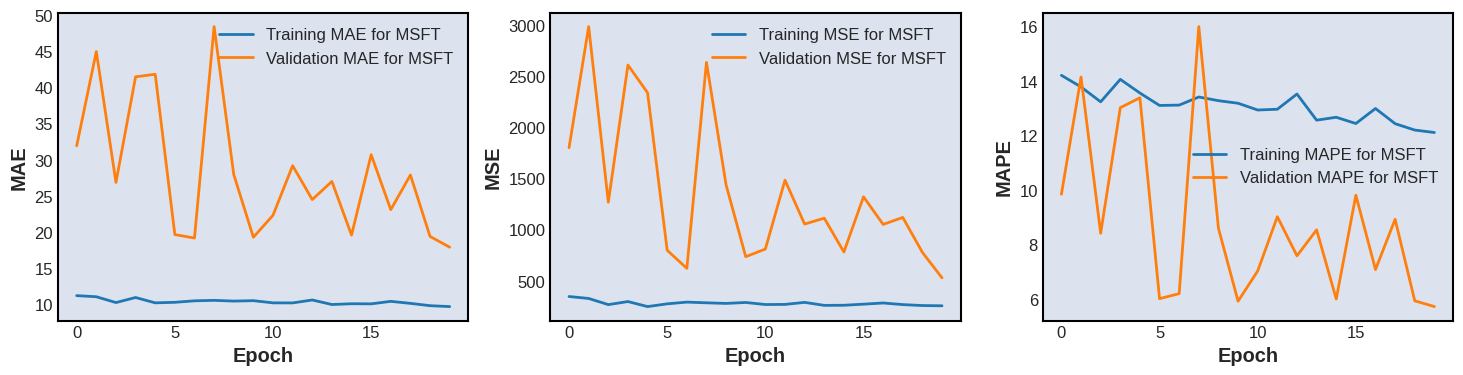

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 67.1422 - mae: 4.8796 - mse: 67.1422 - mape: 11.9599 - val_loss: 136.8217 - val_mae: 11.0794 - val_mse: 136.8217 - val_mape: 6.7195
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 64.1499 - mae: 4.8052 - mse: 64.1499 - mape: 11.7401 - val_loss: 116.5511 - val_mae: 10.1792 - val_mse: 116.5511 - val_mape: 6.1737
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 59.8768 - mae: 4.6990 - mse: 59.8768 - mape: 11.5052 - val_loss: 29.1909 - val_mae: 4.5534 - val_mse: 29.1909 - val_mape: 2.7103
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 60.9018 - mae: 4.6824 - mse: 60.9018 - mape: 11.4216 - val_loss: 76.6854 - val_mae: 8.0681 - val_mse: 76.6854 - val_mape: 4.8738
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 64.5800 - mae: 4.8224 - mse: 64.5800 - mape: 11.8809 - val_loss: 94.9915 - val_mae: 9.1244 - val_mse: 94.9915 - val_ma

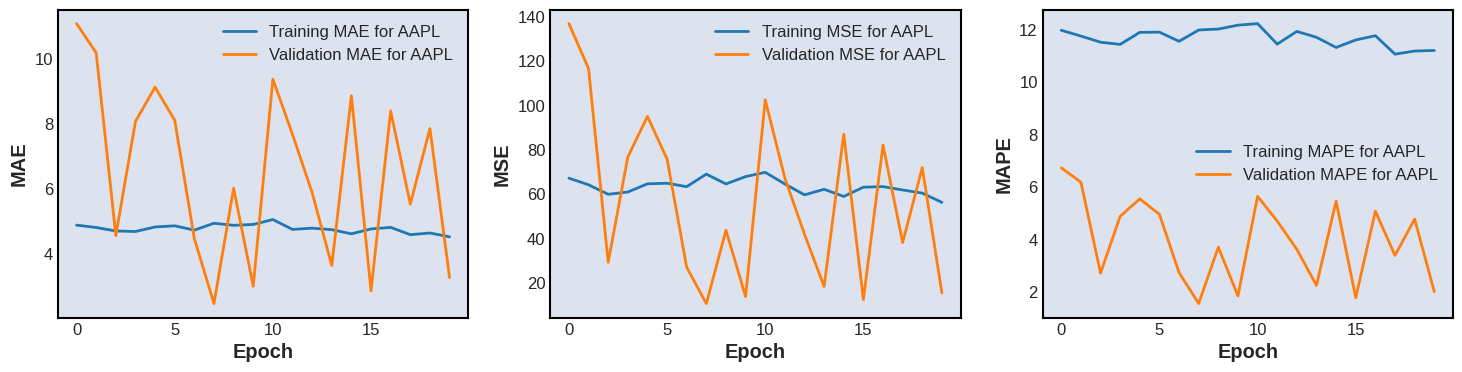

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 50.8985 - mae: 4.7790 - mse: 50.8985 - mape: 11.3055 - val_loss: 25.3233 - val_mae: 4.4884 - val_mse: 25.3233 - val_mape: 3.7395
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 55.4433 - mae: 4.9893 - mse: 55.4433 - mape: 11.8238 - val_loss: 14.8123 - val_mae: 3.1987 - val_mse: 14.8123 - val_mape: 2.7032
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 54.7804 - mae: 4.7797 - mse: 54.7804 - mape: 11.1735 - val_loss: 18.8190 - val_mae: 3.6662 - val_mse: 18.8190 - val_mape: 2.9923
Epoch 4/20
91/91 [==============================] - 0s 4ms/step - loss: 54.8436 - mae: 4.7826 - mse: 54.8436 - mape: 11.1010 - val_loss: 42.9442 - val_mae: 5.8600 - val_mse: 42.9442 - val_mape: 4.7222
Epoch 5/20
91/91 [==============================] - 0s 4ms/step - loss: 54.1819 - mae: 4.8762 - mse: 54.1819 - mape: 11.4825 - val_loss: 28.7388 - val_mae: 4.8258 - val_mse: 28.7388 - val_mape: 4.

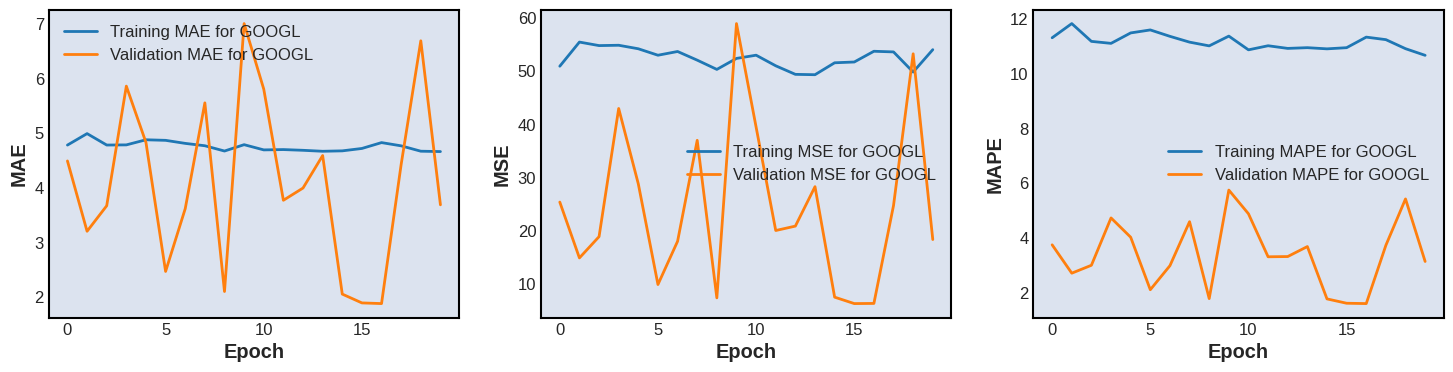

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 578.6044 - mae: 15.7097 - mse: 578.6044 - mape: 13.3085 - val_loss: 478.5695 - val_mae: 16.8368 - val_mse: 478.5695 - val_mape: 6.3686
Epoch 2/20
91/91 [==============================] - 0s 4ms/step - loss: 531.7216 - mae: 15.0628 - mse: 531.7216 - mape: 12.7747 - val_loss: 478.0584 - val_mae: 18.0557 - val_mse: 478.0584 - val_mape: 7.4381
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 561.0522 - mae: 15.5439 - mse: 561.0522 - mape: 13.2964 - val_loss: 111.3450 - val_mae: 7.4542 - val_mse: 111.3450 - val_mape: 3.7467
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 504.9117 - mae: 14.6182 - mse: 504.9117 - mape: 12.2519 - val_loss: 160.3358 - val_mae: 10.3201 - val_mse: 160.3358 - val_mape: 4.5521
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 514.9955 - mae: 14.9721 - mse: 514.9955 - mape: 12.8400 - val_loss: 84.4021 - val_mae: 6.4246 - val_m

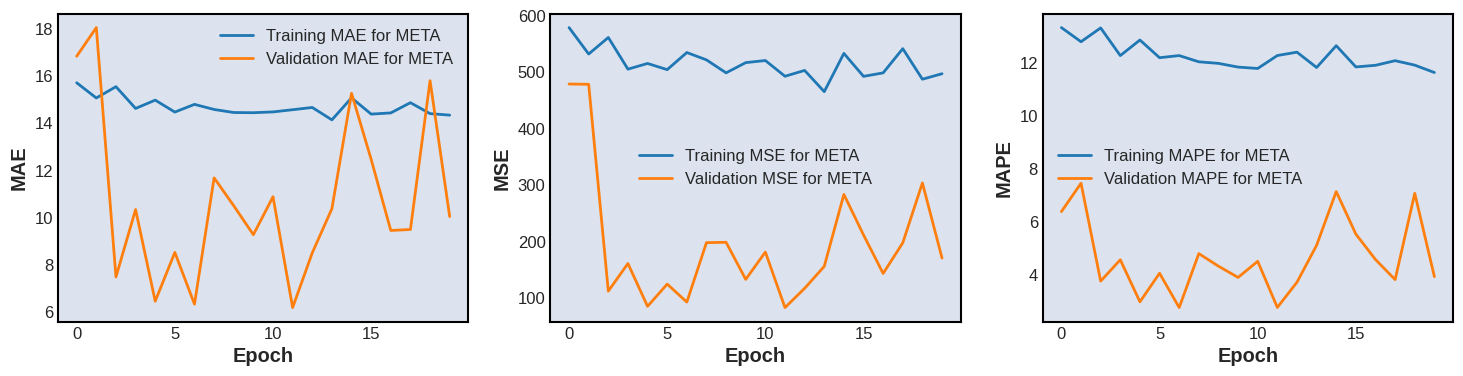

In [52]:
fit_predict(gru_model, train_test, main_tickers, n_epochs)

Epoch 1/20
 1/91 [..............................] - ETA: 0s - loss: 309.3951 - mae: 17.4950 - mse: 309.3951 - mape: 28156.4473

91/91 [==============================] - 0s 4ms/step - loss: 33.1277 - mae: 3.1842 - mse: 33.1277 - mape: 263106.3438 - val_loss: 0.0240 - val_mae: 0.1281 - val_mse: 0.0240 - val_mape: 17.9741
Epoch 2/20
91/91 [==============================] - 0s 4ms/step - loss: 0.9915 - mae: 0.7408 - mse: 0.9915 - mape: 909195.5625 - val_loss: 0.0544 - val_mae: 0.1964 - val_mse: 0.0544 - val_mape: 33.8680
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.7389 - mae: 0.6354 - mse: 0.7389 - mape: 744828.5625 - val_loss: 0.0669 - val_mae: 0.2196 - val_mse: 0.0669 - val_mape: 37.7352
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.5595 - mae: 0.5681 - mse: 0.5595 - mape: 779597.8750 - val_loss: 0.0468 - val_mae: 0.1820 - val_mse: 0.0468 - val_mape: 31.3648
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.5626 - mae: 0.5487 - mse: 0.5626 - mape: 109448.8203 - val_loss: 0.0895 - val_mae: 0.2629 - val_mse: 0.0895 - val_mape: 44.4895

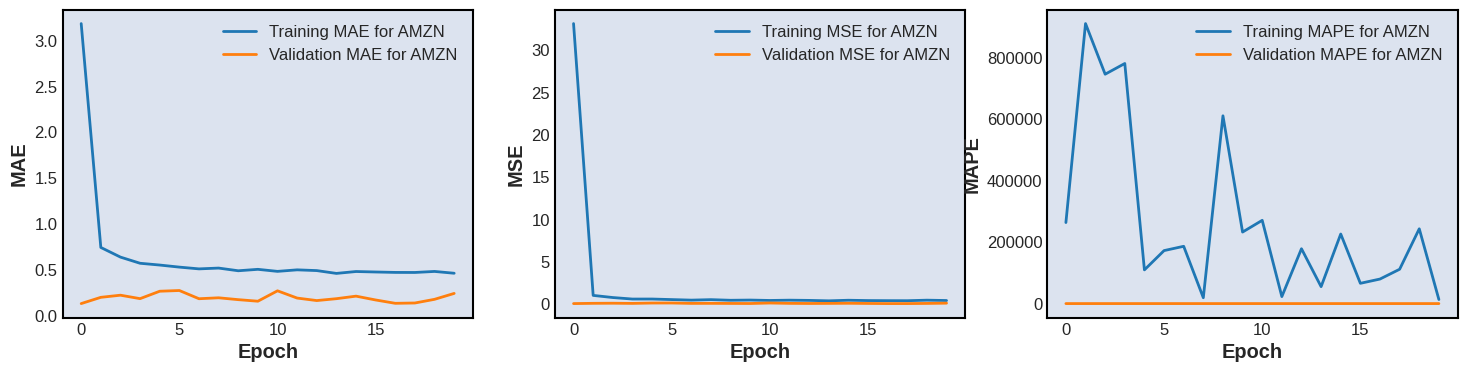

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3279 - mae: 0.4366 - mse: 0.3279 - mape: 165838.3438 - val_loss: 0.0195 - val_mae: 0.1142 - val_mse: 0.0195 - val_mape: 16.9432
Epoch 2/20
91/91 [==============================] - 0s 4ms/step - loss: 0.3198 - mae: 0.4383 - mse: 0.3198 - mape: 401068.5000 - val_loss: 0.0198 - val_mae: 0.1160 - val_mse: 0.0198 - val_mape: 17.1830
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3219 - mae: 0.4408 - mse: 0.3219 - mape: 189525.4531 - val_loss: 0.0090 - val_mae: 0.0800 - val_mse: 0.0090 - val_mape: 11.3075
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3314 - mae: 0.4380 - mse: 0.3314 - mape: 89124.1797 - val_loss: 0.0239 - val_mae: 0.1318 - val_mse: 0.0239 - val_mape: 19.3883
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3087 - mae: 0.4298 - mse: 0.3087 - mape: 82727.7812 - val_loss: 0.0147 - val_mae: 0.0986 - val_mse: 0.0147 - val_mape: 

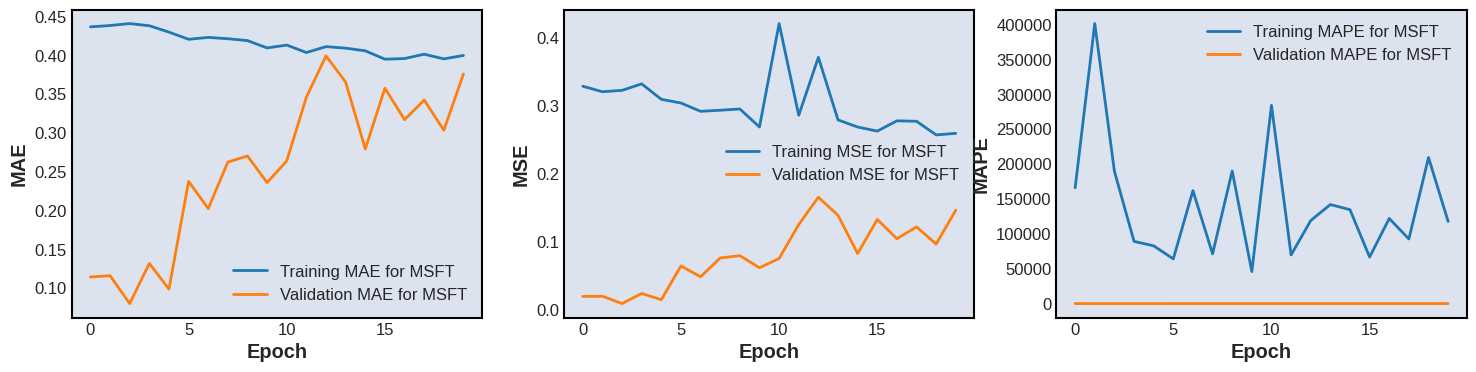

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 0.2512 - mae: 0.3813 - mse: 0.2512 - mape: 714.2811 - val_loss: 0.1200 - val_mae: 0.3417 - val_mse: 0.1200 - val_mape: 43.3115
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2740 - mae: 0.3952 - mse: 0.2740 - mape: 701.7981 - val_loss: 0.1539 - val_mae: 0.3878 - val_mse: 0.1539 - val_mape: 49.0749
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2589 - mae: 0.3964 - mse: 0.2589 - mape: 749.9315 - val_loss: 0.0970 - val_mae: 0.3058 - val_mse: 0.0970 - val_mape: 38.8646
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3427 - mae: 0.3862 - mse: 0.3427 - mape: 680.6635 - val_loss: 0.1486 - val_mae: 0.3808 - val_mse: 0.1486 - val_mape: 48.2141
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2353 - mae: 0.3791 - mse: 0.2353 - mape: 728.0380 - val_loss: 0.1151 - val_mae: 0.3341 - val_mse: 0.1151 - val_mape: 42.3930
Epoch

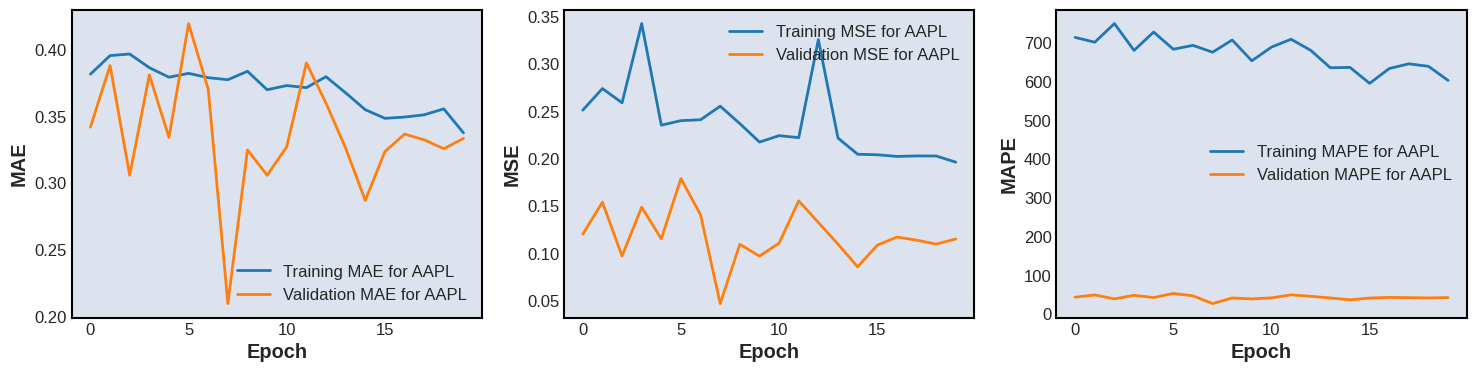

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1880 - mae: 0.3396 - mse: 0.1880 - mape: 139932.2656 - val_loss: 0.1114 - val_mae: 0.3256 - val_mse: 0.1114 - val_mape: 44.0614
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1928 - mae: 0.3457 - mse: 0.1928 - mape: 314131.2500 - val_loss: 0.0997 - val_mae: 0.3068 - val_mse: 0.0997 - val_mape: 41.6425
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1770 - mae: 0.3321 - mse: 0.1770 - mape: 87726.4922 - val_loss: 0.0925 - val_mae: 0.2947 - val_mse: 0.0925 - val_mape: 40.0785
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1857 - mae: 0.3361 - mse: 0.1857 - mape: 4257.4609 - val_loss: 0.0818 - val_mae: 0.2762 - val_mse: 0.0818 - val_mape: 37.6335
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2087 - mae: 0.3429 - mse: 0.2087 - mape: 211366.2344 - val_loss: 0.1131 - val_mae: 0.3287 - val_mse: 0.1131 - val_mape: 4

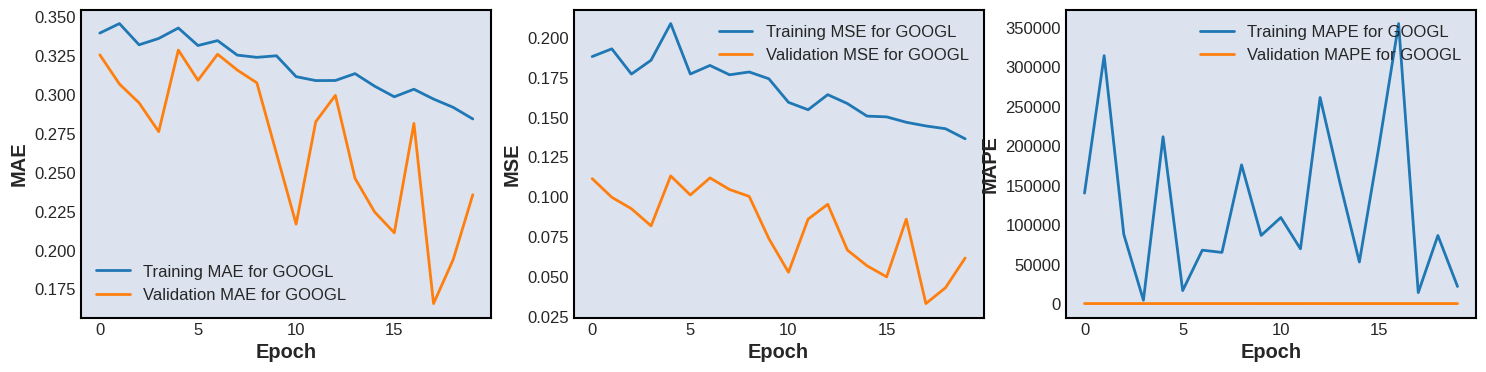

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1295 - mae: 0.2782 - mse: 0.1295 - mape: 67096.7500 - val_loss: 0.0979 - val_mae: 0.3003 - val_mse: 0.0979 - val_mape: 64.4010
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1133 - mae: 0.2612 - mse: 0.1133 - mape: 93437.4766 - val_loss: 0.1160 - val_mae: 0.3276 - val_mse: 0.1160 - val_mape: 70.1862
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1158 - mae: 0.2674 - mse: 0.1158 - mape: 11917.5674 - val_loss: 0.0547 - val_mae: 0.2195 - val_mse: 0.0547 - val_mape: 48.0298
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1262 - mae: 0.2725 - mse: 0.1262 - mape: 13299.2363 - val_loss: 0.0511 - val_mae: 0.2148 - val_mse: 0.0511 - val_mape: 46.5743
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1163 - mae: 0.2665 - mse: 0.1163 - mape: 193882.9062 - val_loss: 0.1006 - val_mae: 0.3053 - val_mse: 0.1006 - val_mape: 65

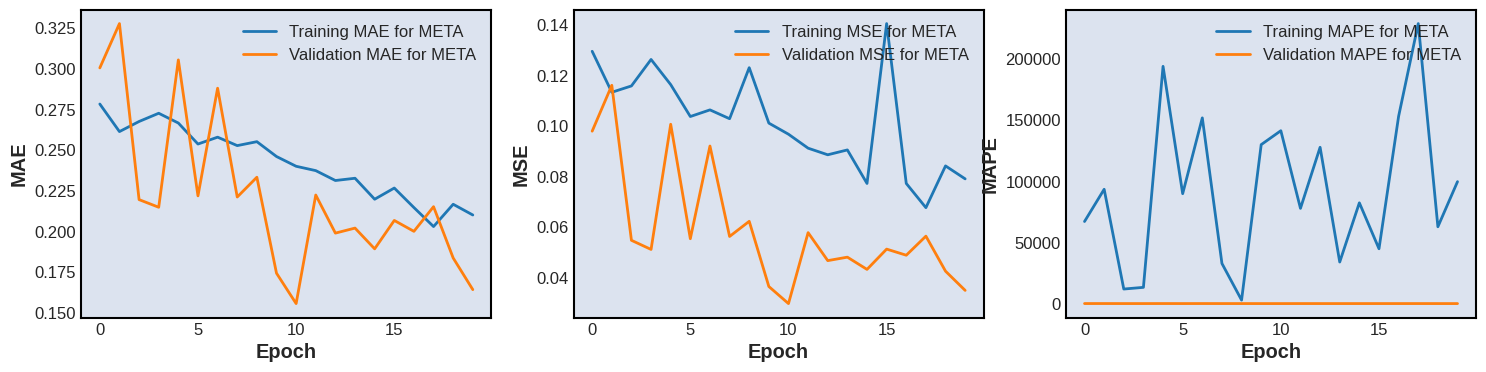

In [53]:
fit_predict(gru_model, train_test_scaled, main_tickers, n_epochs)

### Bi-Directional LSTM

In [54]:
bi_lstm_model = Sequential([layers.Input((window_size, 1)),
                    layers.Bidirectional(layers.LSTM(64)),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(1)])

bi_lstm_model.compile(loss='mse', 
              optimizer=Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae'),
                       tf.keras.metrics.MeanSquaredError(name='mse'),
                       tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])

bi_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               33792     
 al)                                                             
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                      

Epoch 1/20


91/91 [==============================] - 3s 8ms/step - loss: 3713.5688 - mae: 39.3859 - mse: 3713.5688 - mape: 68.7740 - val_loss: 4148.2944 - val_mae: 58.8633 - val_mse: 4148.2944 - val_mape: 42.8129
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 433.3026 - mae: 11.3412 - mse: 433.3026 - mape: 21.4224 - val_loss: 121.3005 - val_mae: 8.9555 - val_mse: 121.3005 - val_mape: 6.9869
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 258.8908 - mae: 9.3000 - mse: 258.8908 - mape: 18.8045 - val_loss: 95.3047 - val_mae: 7.3632 - val_mse: 95.3047 - val_mape: 5.4057
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 266.9653 - mae: 9.3614 - mse: 266.9653 - mape: 19.2262 - val_loss: 63.8769 - val_mae: 6.1992 - val_mse: 63.8769 - val_mape: 4.5176
Epoch 5/20
91/91 [==============================] - 0s 4ms/step - loss: 242.6930 - mae: 8.9202 - mse: 242.6930 - mape: 18.2667 - val_loss: 71.8199 - val_mae: 6.7413 - val_mse: 71.8199 - v

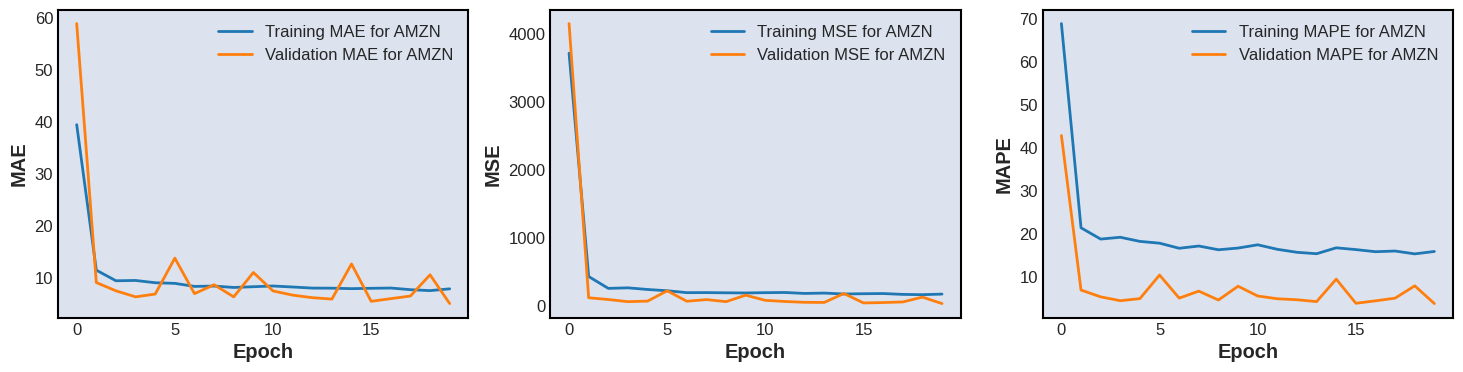

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 446.3739 - mae: 12.7485 - mse: 446.3739 - mape: 15.7445 - val_loss: 2482.5696 - val_mae: 39.3030 - val_mse: 2482.5696 - val_mape: 12.2404
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 396.8719 - mae: 12.3485 - mse: 396.8719 - mape: 15.5295 - val_loss: 2630.8311 - val_mae: 40.9618 - val_mse: 2630.8311 - val_mape: 12.7908
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 393.9780 - mae: 12.1355 - mse: 393.9780 - mape: 15.2979 - val_loss: 1726.6454 - val_mae: 32.0148 - val_mse: 1726.6454 - val_mape: 9.9880
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 406.2074 - mae: 12.4332 - mse: 406.2074 - mape: 15.6183 - val_loss: 1257.7805 - val_mae: 28.1942 - val_mse: 1257.7805 - val_mape: 9.0630
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 386.4955 - mae: 12.2835 - mse: 386.4955 - mape: 15.5026 - val_loss: 1303.4269 - val_mae: 2

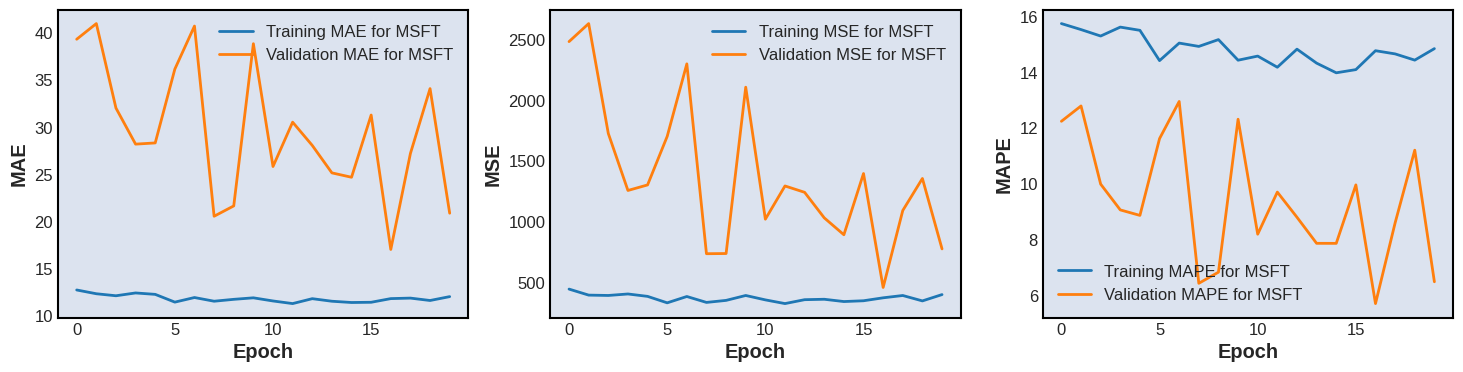

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 85.5938 - mae: 5.5785 - mse: 85.5938 - mape: 13.7216 - val_loss: 36.4898 - val_mae: 4.8693 - val_mse: 36.4898 - val_mape: 2.9906
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 80.9999 - mae: 5.4248 - mse: 80.9999 - mape: 13.5163 - val_loss: 115.1745 - val_mae: 9.9158 - val_mse: 115.1745 - val_mape: 6.1535
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 88.3129 - mae: 5.5328 - mse: 88.3129 - mape: 13.3586 - val_loss: 30.5738 - val_mae: 4.5589 - val_mse: 30.5738 - val_mape: 2.8385
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 81.5668 - mae: 5.4694 - mse: 81.5668 - mape: 13.2363 - val_loss: 20.7422 - val_mae: 3.6267 - val_mse: 20.7422 - val_mape: 2.2632
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 92.1644 - mae: 5.5994 - mse: 92.1644 - mape: 13.2142 - val_loss: 62.4643 - val_mae: 7.0081 - val_mse: 62.4643 - val_mape: 

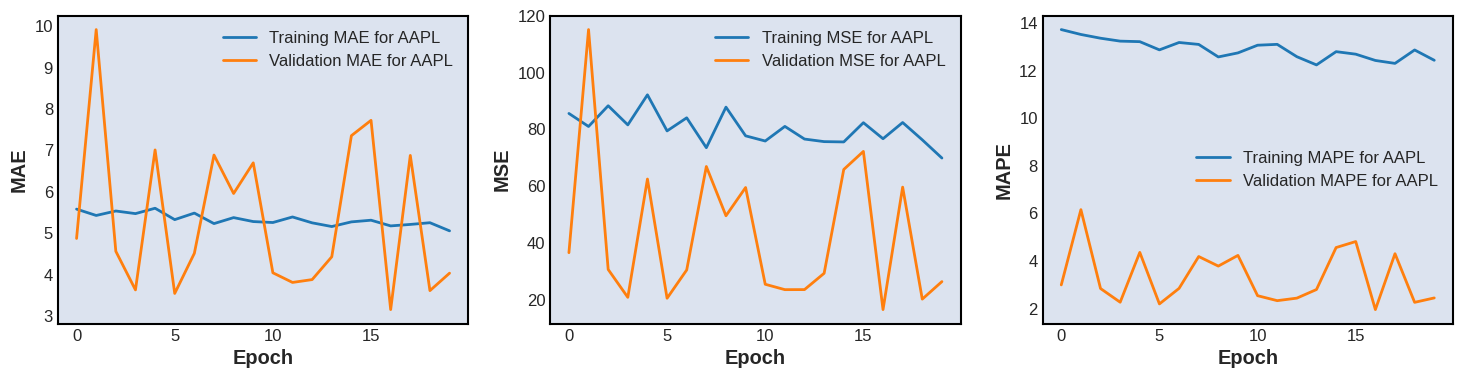

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 67.5119 - mae: 5.4479 - mse: 67.5119 - mape: 12.8746 - val_loss: 28.3753 - val_mae: 4.6720 - val_mse: 28.3753 - val_mape: 3.8680
Epoch 2/20
91/91 [==============================] - 0s 4ms/step - loss: 68.0485 - mae: 5.3280 - mse: 68.0485 - mape: 12.4513 - val_loss: 9.5317 - val_mae: 2.3557 - val_mse: 9.5317 - val_mape: 2.0314
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 64.2331 - mae: 5.3578 - mse: 64.2331 - mape: 12.5556 - val_loss: 16.6894 - val_mae: 3.3798 - val_mse: 16.6894 - val_mape: 2.7625
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 68.0286 - mae: 5.2364 - mse: 68.0286 - mape: 12.0715 - val_loss: 36.6174 - val_mae: 5.3466 - val_mse: 36.6174 - val_mape: 4.5867
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 60.8418 - mae: 5.1519 - mse: 60.8418 - mape: 12.1774 - val_loss: 9.8412 - val_mae: 2.4606 - val_mse: 9.8412 - val_mape: 2.0670

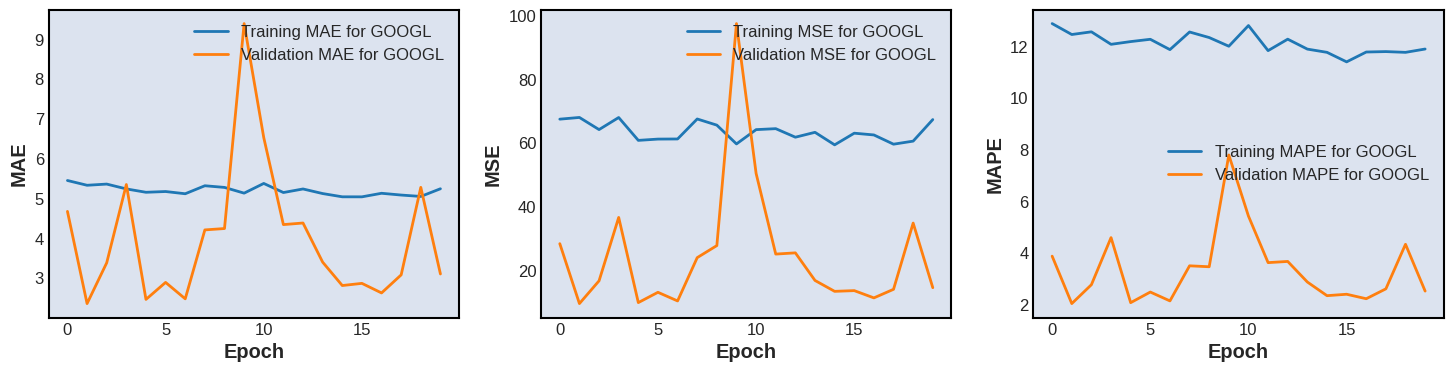

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 784.0864 - mae: 17.8435 - mse: 784.0864 - mape: 14.5183 - val_loss: 1087.5820 - val_mae: 30.2428 - val_mse: 1087.5820 - val_mape: 12.7096
Epoch 2/20
91/91 [==============================] - 0s 4ms/step - loss: 646.8788 - mae: 16.6274 - mse: 646.8788 - mape: 13.9701 - val_loss: 190.4603 - val_mae: 11.1243 - val_mse: 190.4603 - val_mape: 5.3374
Epoch 3/20
91/91 [==============================] - 0s 4ms/step - loss: 662.4075 - mae: 16.6216 - mse: 662.4075 - mape: 13.5167 - val_loss: 295.4107 - val_mae: 14.7128 - val_mse: 295.4107 - val_mape: 6.6241
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 669.4877 - mae: 16.6354 - mse: 669.4877 - mape: 13.4318 - val_loss: 544.3414 - val_mae: 18.8666 - val_mse: 544.3414 - val_mape: 7.1546
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 616.3965 - mae: 16.0141 - mse: 616.3965 - mape: 12.9334 - val_loss: 161.0397 - val_mae: 9.8382 - 

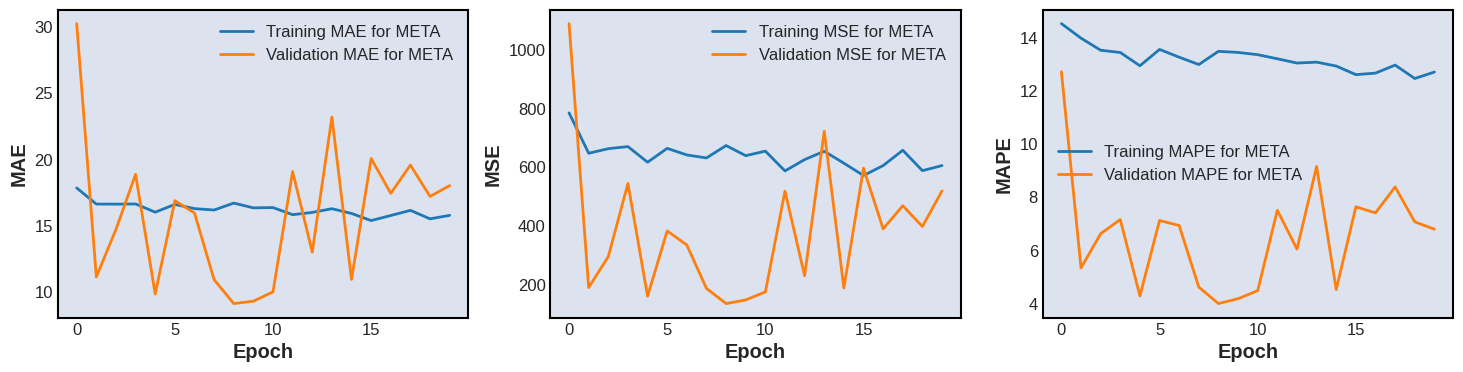

In [55]:
fit_predict(bi_lstm_model, train_test, main_tickers, n_epochs)

Epoch 1/20
 1/91 [..............................] - ETA: 0s - loss: 628.3428 - mae: 24.8146 - mse: 628.3428 - mape: 54323.0781

91/91 [==============================] - 0s 4ms/step - loss: 54.0220 - mae: 4.1998 - mse: 54.0220 - mape: 514439.6250 - val_loss: 0.0228 - val_mae: 0.1263 - val_mse: 0.0228 - val_mape: 19.1148
Epoch 2/20
91/91 [==============================] - 0s 4ms/step - loss: 1.3591 - mae: 0.8426 - mse: 1.3591 - mape: 80976.5156 - val_loss: 0.0848 - val_mae: 0.2565 - val_mse: 0.0848 - val_mape: 43.3556
Epoch 3/20
91/91 [==============================] - 0s 4ms/step - loss: 0.8856 - mae: 0.7099 - mse: 0.8856 - mape: 97474.5625 - val_loss: 0.1053 - val_mae: 0.2935 - val_mse: 0.1053 - val_mape: 48.9837
Epoch 4/20
91/91 [==============================] - 0s 4ms/step - loss: 0.7296 - mae: 0.6502 - mse: 0.7296 - mape: 125454.3906 - val_loss: 0.0280 - val_mae: 0.1409 - val_mse: 0.0280 - val_mape: 23.8531
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.7515 - mae: 0.6310 - mse: 0.7515 - mape: 385393.4688 - val_loss: 0.0486 - val_mae: 0.1854 - val_mse: 0.0486 - val_mape: 31.9816
E

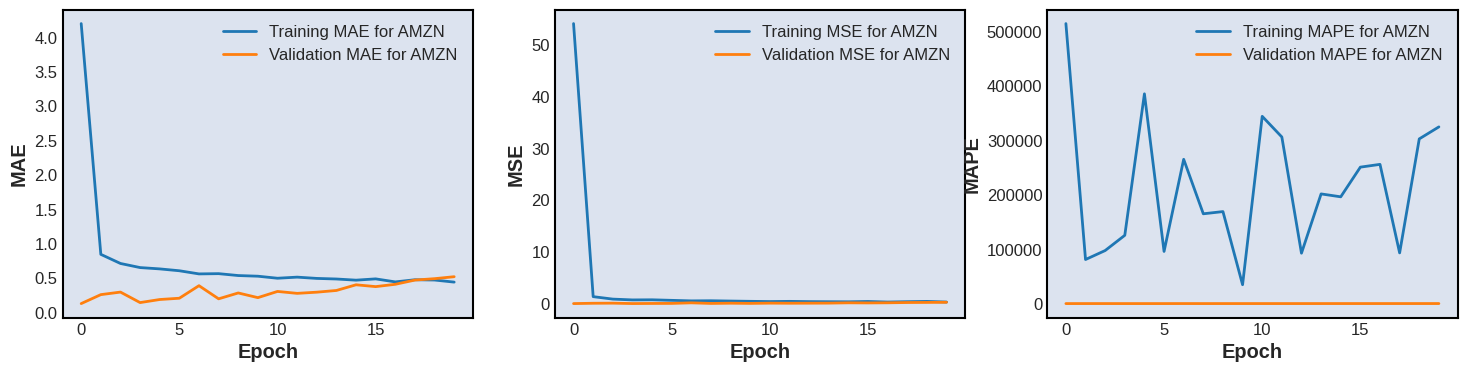

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 0.3918 - mae: 0.4625 - mse: 0.3918 - mape: 325519.4062 - val_loss: 0.2665 - val_mae: 0.5122 - val_mse: 0.2665 - val_mape: 70.5253
Epoch 2/20
91/91 [==============================] - 0s 4ms/step - loss: 0.3147 - mae: 0.4425 - mse: 0.3147 - mape: 114379.4219 - val_loss: 0.2545 - val_mae: 0.5000 - val_mse: 0.2545 - val_mape: 68.9156
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3385 - mae: 0.4473 - mse: 0.3385 - mape: 37957.5312 - val_loss: 0.2149 - val_mae: 0.4584 - val_mse: 0.2149 - val_mape: 63.3418
Epoch 4/20
91/91 [==============================] - 0s 4ms/step - loss: 0.3523 - mae: 0.4531 - mse: 0.3523 - mape: 109443.6250 - val_loss: 0.1888 - val_mae: 0.4299 - val_mse: 0.1888 - val_mape: 59.3506
Epoch 5/20
91/91 [==============================] - 0s 4ms/step - loss: 0.3086 - mae: 0.4341 - mse: 0.3086 - mape: 39725.8125 - val_loss: 0.2106 - val_mae: 0.4549 - val_mse: 0.2106 - val_mape: 

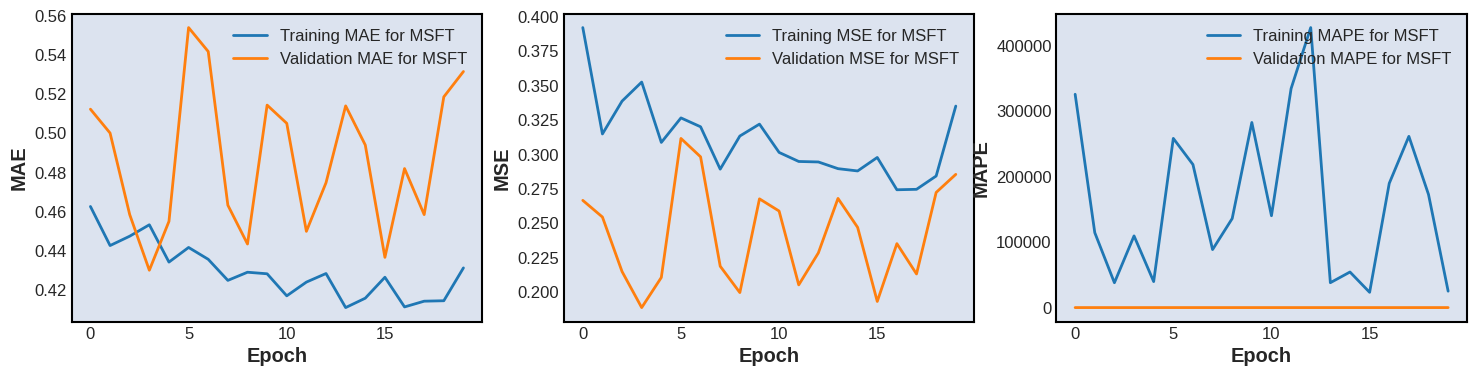

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 0.2863 - mae: 0.4129 - mse: 0.2863 - mape: 750.9835 - val_loss: 0.1813 - val_mae: 0.4230 - val_mse: 0.1813 - val_mape: 53.3049
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3810 - mae: 0.4052 - mse: 0.3810 - mape: 716.4277 - val_loss: 0.1333 - val_mae: 0.3620 - val_mse: 0.1333 - val_mape: 45.6918
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2886 - mae: 0.4179 - mse: 0.2886 - mape: 807.8167 - val_loss: 0.1622 - val_mae: 0.4000 - val_mse: 0.1622 - val_mape: 50.4186
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2629 - mae: 0.4035 - mse: 0.2629 - mape: 681.5959 - val_loss: 0.2310 - val_mae: 0.4779 - val_mse: 0.2310 - val_mape: 60.1877
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2684 - mae: 0.4032 - mse: 0.2684 - mape: 708.6539 - val_loss: 0.2140 - val_mae: 0.4600 - val_mse: 0.2140 - val_mape: 57.9305
Epoch

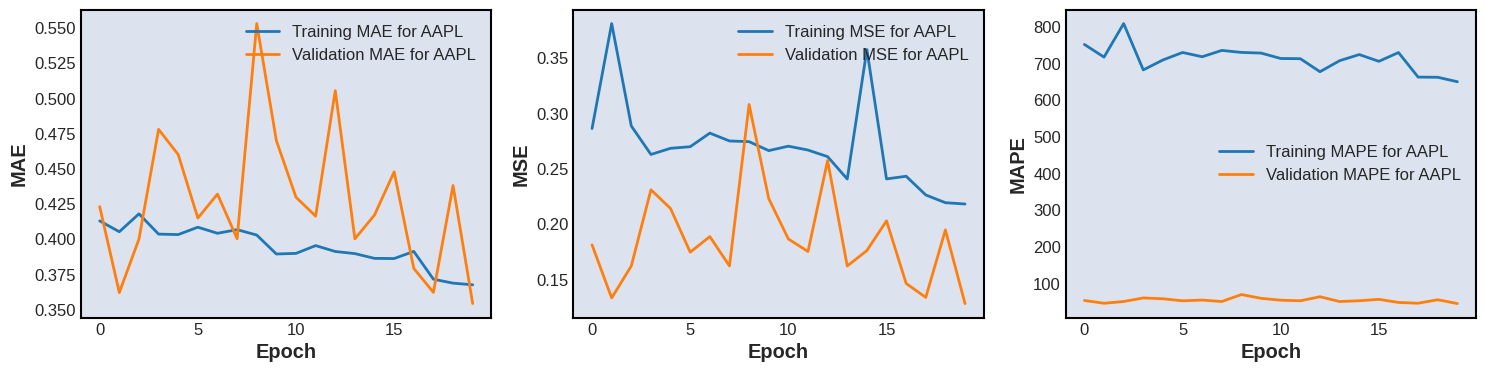

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 0.2379 - mae: 0.3687 - mse: 0.2379 - mape: 141828.4375 - val_loss: 0.2355 - val_mae: 0.4809 - val_mse: 0.2355 - val_mape: 64.1385
Epoch 2/20
91/91 [==============================] - 0s 4ms/step - loss: 0.2193 - mae: 0.3692 - mse: 0.2193 - mape: 117222.7578 - val_loss: 0.1411 - val_mae: 0.3707 - val_mse: 0.1411 - val_mape: 49.6403
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2197 - mae: 0.3709 - mse: 0.2197 - mape: 116914.3750 - val_loss: 0.2396 - val_mae: 0.4849 - val_mse: 0.2396 - val_mape: 64.6933
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2150 - mae: 0.3608 - mse: 0.2150 - mape: 37723.6719 - val_loss: 0.1235 - val_mae: 0.3467 - val_mse: 0.1235 - val_mape: 46.4301
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2246 - mae: 0.3633 - mse: 0.2246 - mape: 43230.9180 - val_loss: 0.1948 - val_mae: 0.4379 - val_mse: 0.1948 - val_mape: 

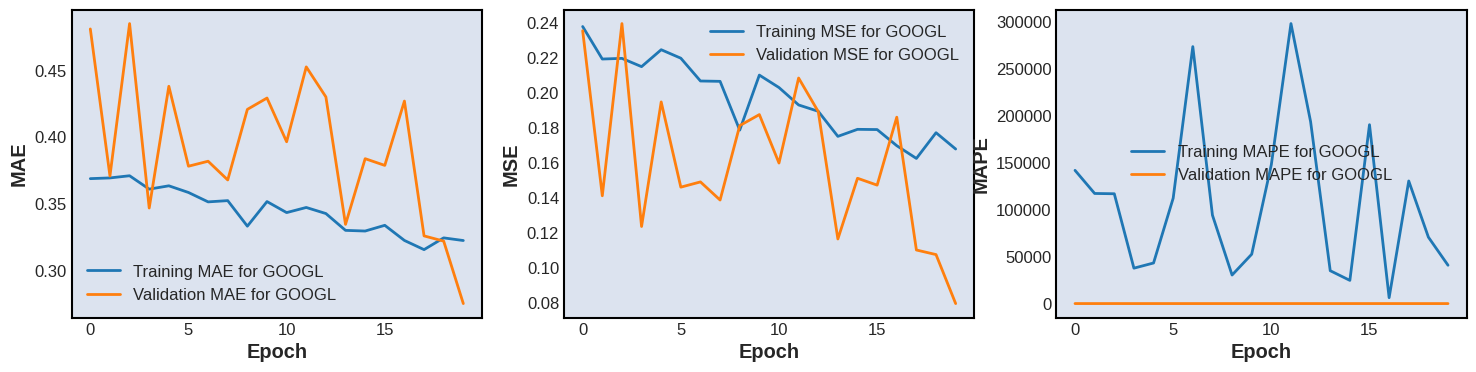

Epoch 1/20
91/91 [==============================] - 0s 4ms/step - loss: 0.1687 - mae: 0.3113 - mse: 0.1687 - mape: 77440.9062 - val_loss: 0.1500 - val_mae: 0.3825 - val_mse: 0.1500 - val_mape: 78.2474
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2717 - mae: 0.3021 - mse: 0.2717 - mape: 218314.8594 - val_loss: 0.1229 - val_mae: 0.3440 - val_mse: 0.1229 - val_mape: 71.3208
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1520 - mae: 0.3035 - mse: 0.1520 - mape: 39946.8125 - val_loss: 0.1379 - val_mae: 0.3649 - val_mse: 0.1379 - val_mape: 75.6535
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1510 - mae: 0.3004 - mse: 0.1510 - mape: 210508.7812 - val_loss: 0.1103 - val_mae: 0.3292 - val_mse: 0.1103 - val_mape: 66.2402
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1382 - mae: 0.2925 - mse: 0.1382 - mape: 34459.0273 - val_loss: 0.1136 - val_mae: 0.3305 - val_mse: 0.1136 - val_mape: 6

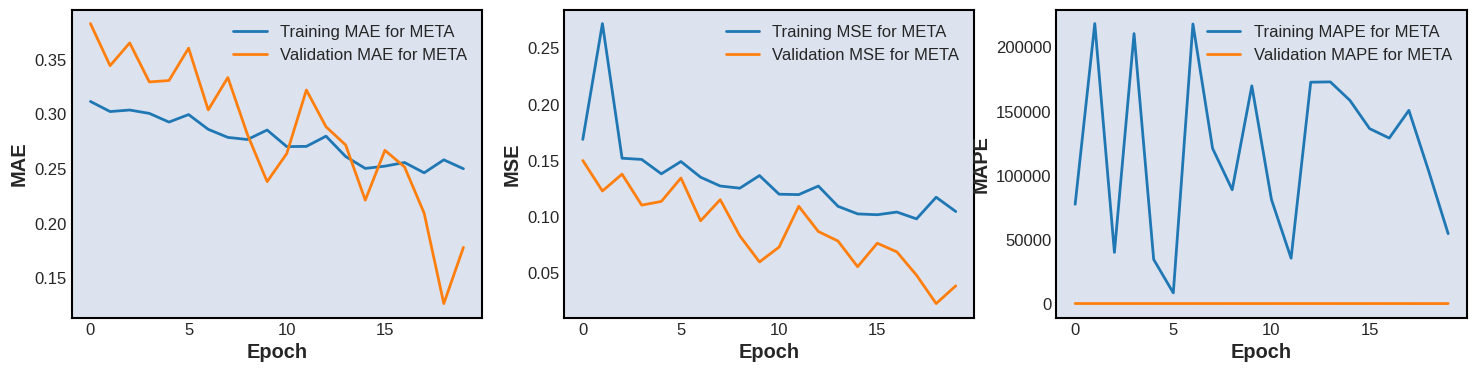

In [56]:
fit_predict(bi_lstm_model, train_test_scaled, main_tickers, n_epochs)

### MLP

In [57]:
mlp_model = Sequential([layers.Input((window_size, 1)),
                    layers.Dense(64, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(1)])

mlp_model.compile(loss='mse', 
              optimizer=Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae'),
                       tf.keras.metrics.MeanSquaredError(name='mse'),
                       tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])

mlp_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10, 64)            128       
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 dense_10 (Dense)            (None, 10, 32)            2080      
                                                                 
 dropout_7 (Dropout)         (None, 10, 32)            0         
                                                                 
 dense_11 (Dense)            (None, 10, 1)             33        
                                                                 


Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20


91/91 [==============================] - 1s 4ms/step - loss: 3612.2805 - mae: 42.3458 - mse: 3612.2812 - mape: 116.2016 - val_loss: 5102.9473 - val_mae: 69.7061 - val_mse: 5102.9473 - val_mape: 53.2889
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 3523.8176 - mae: 41.7743 - mse: 3523.8179 - mape: 117.3023 - val_loss: 4461.4302 - val_mae: 65.0617 - val_mse: 4461.4307 - val_mape: 49.6748
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 3442.9023 - mae: 41.1249 - mse: 3442.9021 - mape: 115.2567 - val_loss: 4310.4023 - val_mae: 63.8411 - val_mse: 4310.4028 - val_mape: 48.6585
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 3319.8115 - mae: 40.2151 - mse: 3319.8105 - mape: 115.6291 - val_loss: 5065.5850 - val_mae: 69.1561 - val_mse: 5065.5850 - val_mape: 52.6228
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 3150.4102 - mae: 39.4417 - mse: 3150.4102 - mape: 118.9340 - val_loss: 5569.3882 - val_

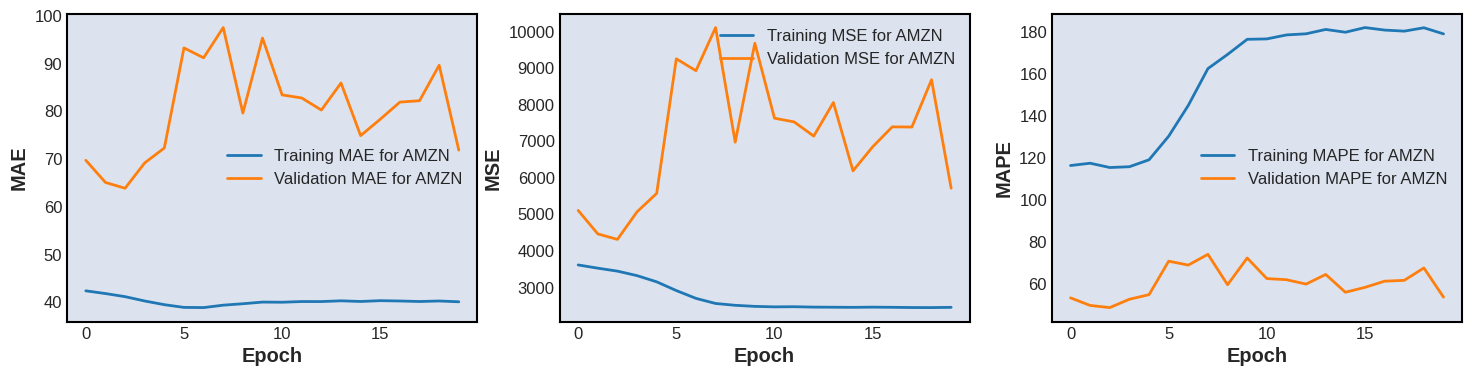

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 4717.7515 - mae: 51.1315 - mse: 4717.7510 - mape: 84.5674 - val_loss: 45043.8398 - val_mae: 209.5251 - val_mse: 45043.8398 - val_mape: 70.8462
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 4597.9375 - mae: 51.8950 - mse: 4597.9365 - mape: 89.3932 - val_loss: 46939.1875 - val_mae: 214.1968 - val_mse: 46939.1875 - val_mape: 72.5227
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 4599.4453 - mae: 52.0860 - mse: 4599.4448 - mape: 90.4991 - val_loss: 49207.1602 - val_mae: 219.3625 - val_mse: 49207.1562 - val_mape: 74.2875
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 4594.6870 - mae: 51.8126 - mse: 4594.6855 - mape: 89.0988 - val_loss: 34165.3398 - val_mae: 181.6757 - val_mse: 34165.3359 - val_mape: 61.2115
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 4602.8633 - mae: 51.8643 - mse: 4602.8633 - mape: 89.7746 - val_loss

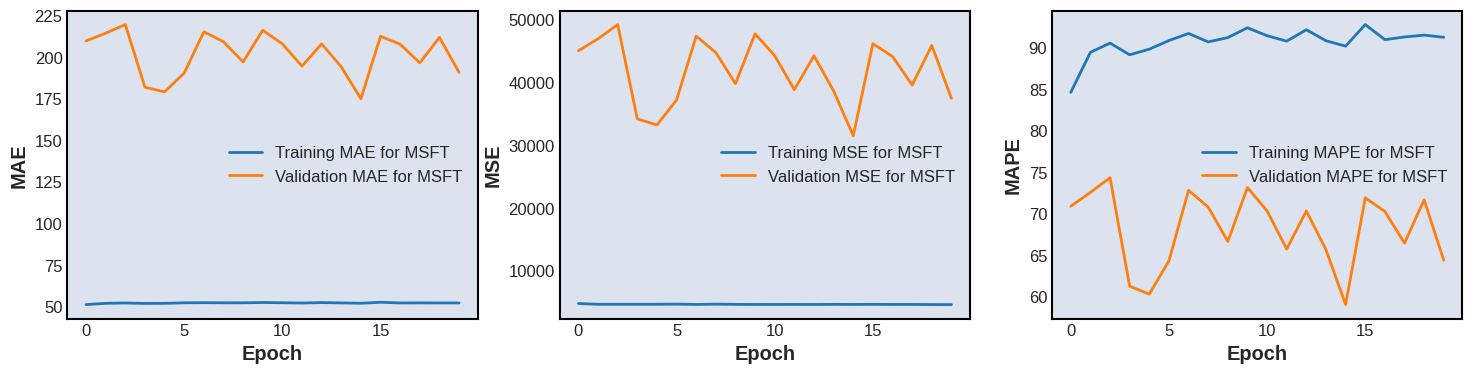

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 1366.6226 - mae: 27.7954 - mse: 1366.6227 - mape: 109.6830 - val_loss: 15739.0049 - val_mae: 124.5157 - val_mse: 15739.0029 - val_mape: 76.5690
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 1180.2782 - mae: 24.7631 - mse: 1180.2781 - mape: 91.2746 - val_loss: 12524.3828 - val_mae: 110.9534 - val_mse: 12524.3828 - val_mape: 68.1682
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 1160.7690 - mae: 24.8860 - mse: 1160.7688 - mape: 93.8707 - val_loss: 13439.2695 - val_mae: 114.9699 - val_mse: 13439.2715 - val_mape: 70.6530
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 1155.4775 - mae: 24.2894 - mse: 1155.4775 - mape: 88.7759 - val_loss: 12681.5059 - val_mae: 111.6472 - val_mse: 12681.5078 - val_mape: 68.5941
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 1150.1873 - mae: 24.4926 - mse: 1150.1873 - mape: 91.1357 - val_los

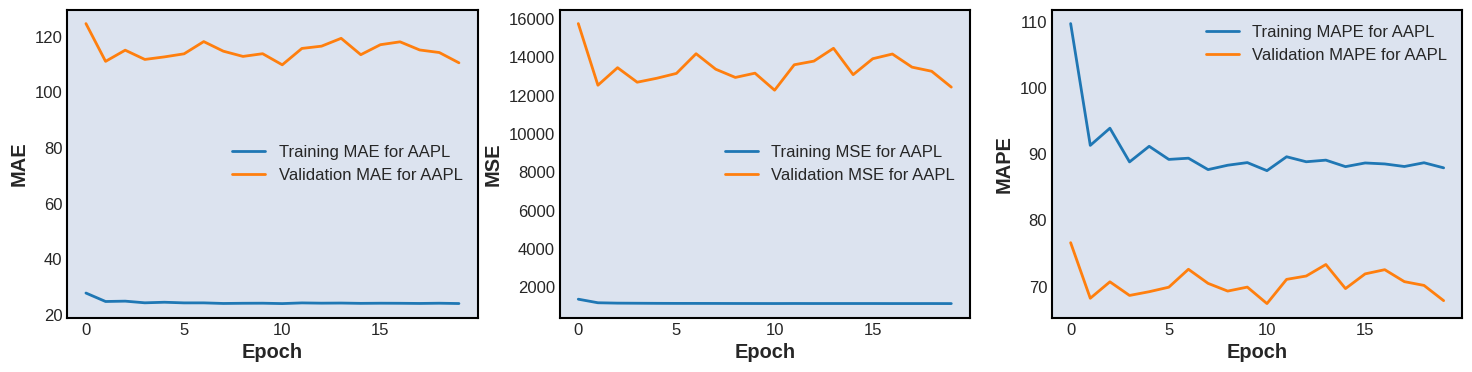

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 741.7600 - mae: 21.2353 - mse: 741.7601 - mape: 74.3955 - val_loss: 6236.4292 - val_mae: 77.2566 - val_mse: 6236.4297 - val_mape: 63.4812
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 741.5286 - mae: 21.1578 - mse: 741.5286 - mape: 73.3225 - val_loss: 5564.7598 - val_mae: 72.8245 - val_mse: 5564.7603 - val_mape: 59.7441
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 741.6781 - mae: 21.2575 - mse: 741.6782 - mape: 74.8849 - val_loss: 6500.1567 - val_mae: 78.9599 - val_mse: 6500.1562 - val_mape: 64.9366
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 741.1995 - mae: 21.1981 - mse: 741.1994 - mape: 73.8130 - val_loss: 5858.6929 - val_mae: 74.7786 - val_mse: 5858.6919 - val_mape: 61.3798
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 740.0432 - mae: 21.1192 - mse: 740.0431 - mape: 73.5629 - val_loss: 5712.6104 - val_mae:

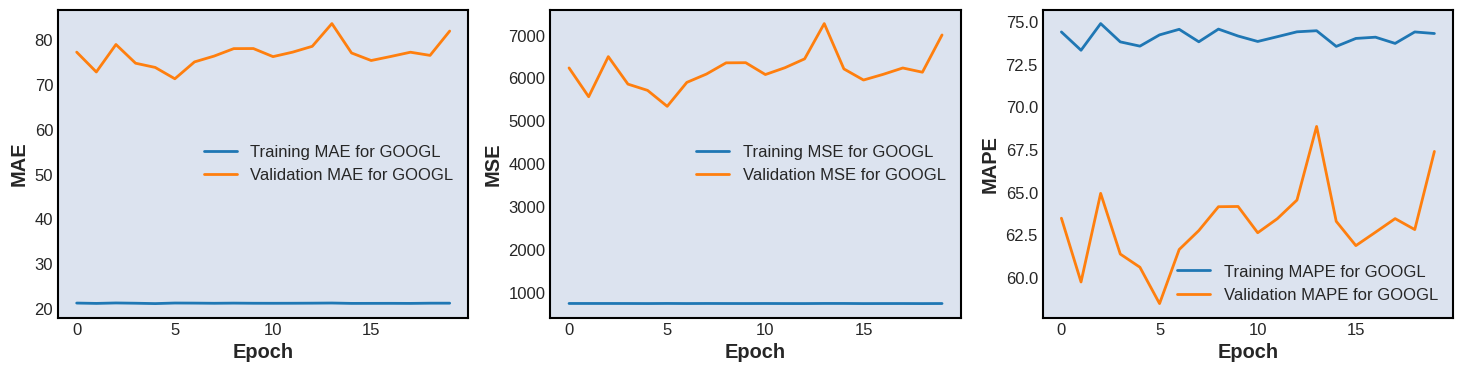

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 8342.2412 - mae: 71.8736 - mse: 8342.2402 - mape: 94.4243 - val_loss: 22566.8340 - val_mae: 133.1878 - val_mse: 22566.8340 - val_mape: 51.6747
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 7391.0034 - mae: 70.6399 - mse: 7391.0034 - mape: 105.5673 - val_loss: 16918.6738 - val_mae: 110.0748 - val_mse: 16918.6719 - val_mape: 40.9308
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 7348.7881 - mae: 70.8906 - mse: 7348.7886 - mape: 108.0893 - val_loss: 20387.4473 - val_mae: 123.4266 - val_mse: 20387.4473 - val_mape: 46.6975
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 7295.1694 - mae: 70.6331 - mse: 7295.1670 - mape: 107.7918 - val_loss: 13627.2637 - val_mae: 97.1146 - val_mse: 13627.2637 - val_mape: 35.7838
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 7345.3560 - mae: 70.9780 - mse: 7345.3579 - mape: 108.3664 - val_l

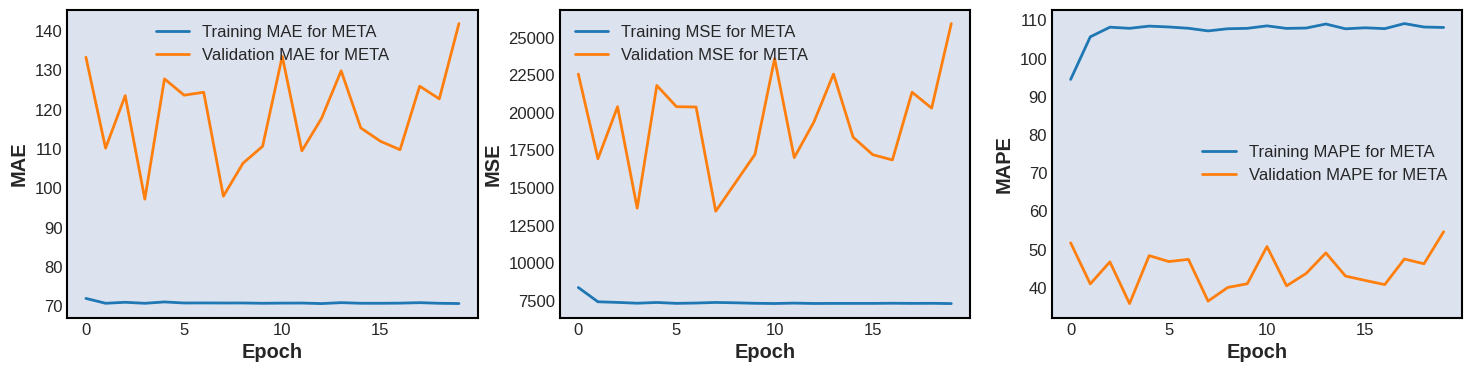

In [58]:
fit_predict(mlp_model, train_test, main_tickers, n_epochs)

Epoch 1/20


91/91 [==============================] - 0s 3ms/step - loss: 3150.1406 - mae: 46.3894 - mse: 3150.1411 - mape: 18931318.0000 - val_loss: 180.0539 - val_mae: 13.4177 - val_mse: 180.0539 - val_mape: 2039.8505
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 100.3088 - mae: 9.6343 - mse: 100.3088 - mape: 2877815.0000 - val_loss: 29.6594 - val_mae: 5.4442 - val_mse: 29.6594 - val_mape: 830.3535
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 38.1395 - mae: 6.0062 - mse: 38.1395 - mape: 2059309.6250 - val_loss: 15.8473 - val_mae: 3.9784 - val_mse: 15.8473 - val_mape: 608.0295
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 21.2725 - mae: 4.3554 - mse: 21.2725 - mape: 1891596.7500 - val_loss: 0.3587 - val_mae: 0.5826 - val_mse: 0.3587 - val_mape: 92.8472
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 5.2348 - mae: 1.6304 - mse: 5.2348 - mape: 523591.2812 - val_loss: 0.0417 - val_mae: 0.1650 - val_

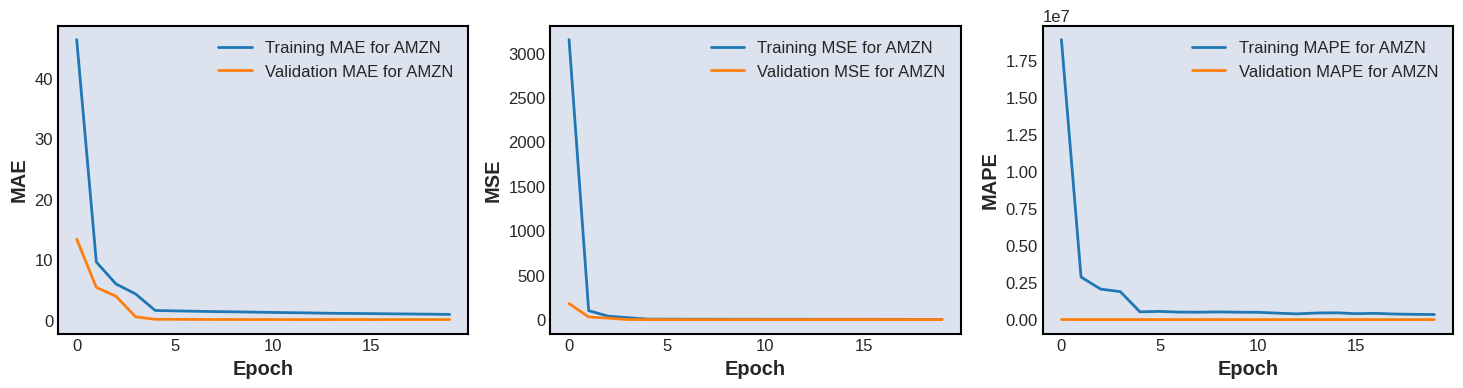

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 1.9535 - mae: 0.9463 - mse: 1.9535 - mape: 325303.5625 - val_loss: 0.0647 - val_mae: 0.2308 - val_mse: 0.0647 - val_mape: 29.1093
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 1.8238 - mae: 0.9095 - mse: 1.8238 - mape: 318935.2188 - val_loss: 0.0605 - val_mae: 0.2213 - val_mse: 0.0605 - val_mape: 27.8301
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 1.7194 - mae: 0.8832 - mse: 1.7194 - mape: 301771.1562 - val_loss: 0.0722 - val_mae: 0.2463 - val_mse: 0.0722 - val_mape: 31.2126
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 1.6398 - mae: 0.8599 - mse: 1.6398 - mape: 283503.9375 - val_loss: 0.0682 - val_mae: 0.2382 - val_mse: 0.0682 - val_mape: 30.1166
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 1.5487 - mae: 0.8332 - mse: 1.5487 - mape: 293557.5625 - val_loss: 0.0796 - val_mae: 0.2609 - val_mse: 0.0796 - val_mape

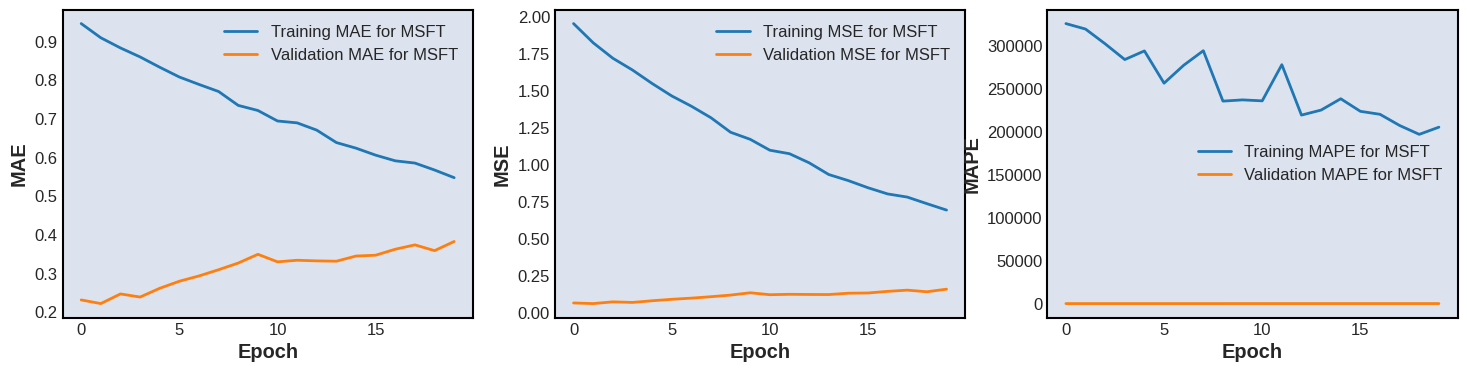

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.6504 - mae: 0.5273 - mse: 0.6504 - mape: 949.3407 - val_loss: 0.2063 - val_mae: 0.4452 - val_mse: 0.2063 - val_mape: 54.2122
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 0.6177 - mae: 0.5114 - mse: 0.6177 - mape: 913.7524 - val_loss: 0.1883 - val_mae: 0.4246 - val_mse: 0.1883 - val_mape: 51.6467
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 0.6041 - mae: 0.5050 - mse: 0.6041 - mape: 908.3182 - val_loss: 0.1907 - val_mae: 0.4274 - val_mse: 0.1907 - val_mape: 51.9995
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.5629 - mae: 0.4861 - mse: 0.5629 - mape: 869.4279 - val_loss: 0.1898 - val_mae: 0.4264 - val_mse: 0.1898 - val_mape: 51.8753
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 0.5473 - mae: 0.4801 - mse: 0.5473 - mape: 861.6675 - val_loss: 0.2007 - val_mae: 0.4390 - val_mse: 0.2007 - val_mape: 53.4416
Epoch

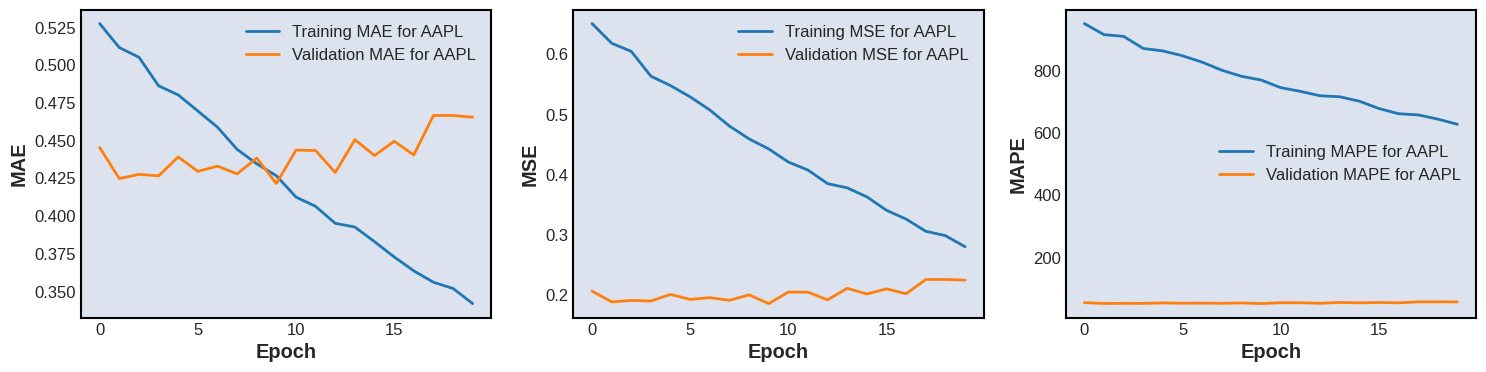

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2530 - mae: 0.3400 - mse: 0.2530 - mape: 149031.3125 - val_loss: 0.1753 - val_mae: 0.3987 - val_mse: 0.1753 - val_mape: 49.1593
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 0.2476 - mae: 0.3362 - mse: 0.2476 - mape: 137898.7656 - val_loss: 0.1866 - val_mae: 0.4127 - val_mse: 0.1866 - val_mape: 50.9861
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 0.2370 - mae: 0.3344 - mse: 0.2370 - mape: 134026.9219 - val_loss: 0.1765 - val_mae: 0.4002 - val_mse: 0.1765 - val_mape: 49.3532
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2235 - mae: 0.3269 - mse: 0.2235 - mape: 156644.4688 - val_loss: 0.1859 - val_mae: 0.4119 - val_mse: 0.1859 - val_mape: 50.8701
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2119 - mae: 0.3200 - mse: 0.2119 - mape: 129611.6562 - val_loss: 0.1910 - val_mae: 0.4179 - val_mse: 0.1910 - val_mape

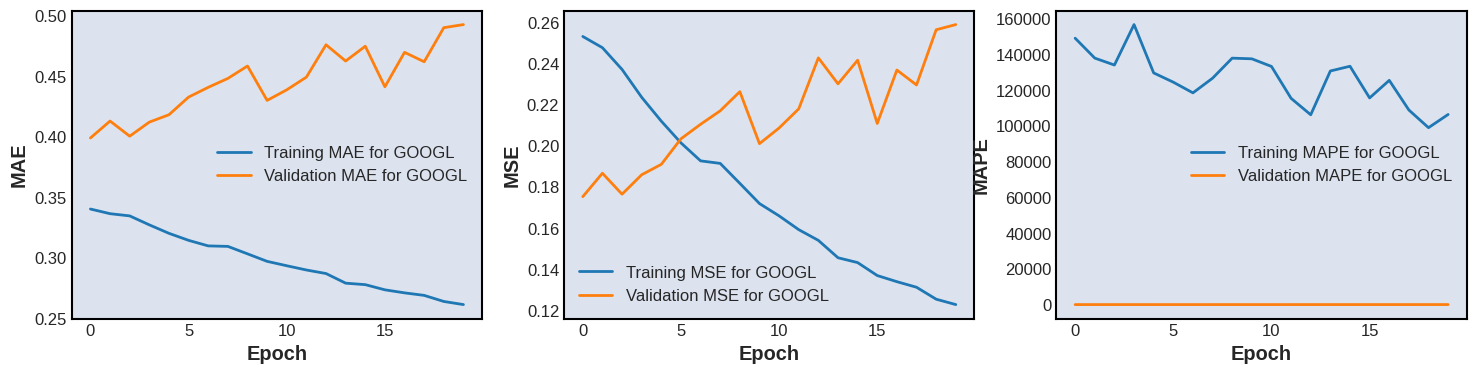

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1260 - mae: 0.2747 - mse: 0.1260 - mape: 120822.8359 - val_loss: 0.1191 - val_mae: 0.2828 - val_mse: 0.1191 - val_mape: 40.8067
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1225 - mae: 0.2719 - mse: 0.1225 - mape: 121748.6719 - val_loss: 0.1214 - val_mae: 0.2859 - val_mse: 0.1214 - val_mape: 41.2225
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1196 - mae: 0.2691 - mse: 0.1196 - mape: 117908.9844 - val_loss: 0.1109 - val_mae: 0.2716 - val_mse: 0.1109 - val_mape: 39.3579
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1195 - mae: 0.2683 - mse: 0.1195 - mape: 122424.4062 - val_loss: 0.1204 - val_mae: 0.2845 - val_mse: 0.1204 - val_mape: 41.0376
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.1175 - mae: 0.2662 - mse: 0.1175 - mape: 131057.3594 - val_loss: 0.1101 - val_mae: 0.2705 - val_mse: 0.1101 - val_mape

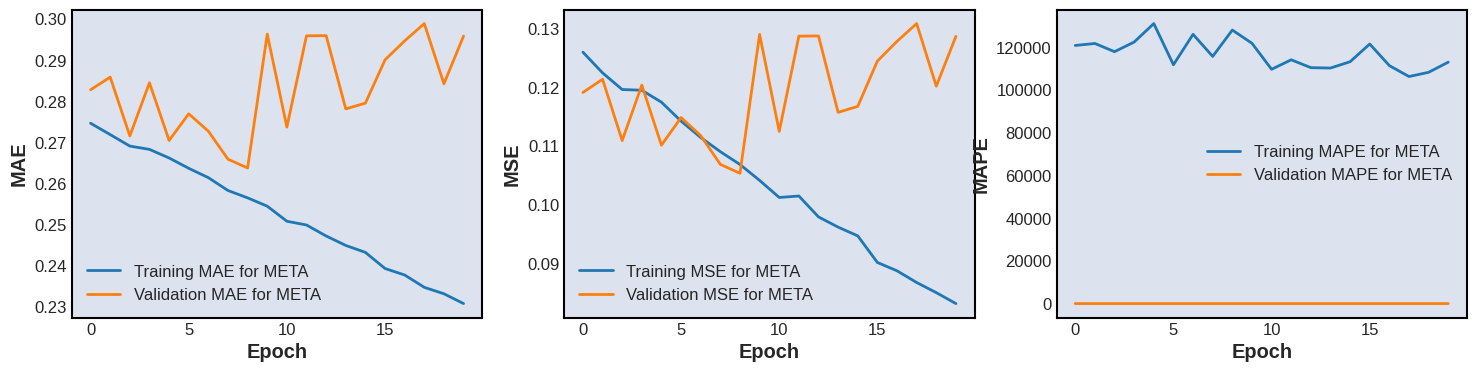

In [59]:
fit_predict(mlp_model, train_test_scaled, main_tickers, n_epochs)

### CNN

In [60]:
cnn_model = Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

cnn_model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae'),
                       tf.keras.metrics.MeanSquaredError(name='mse'),
                       tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])

cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                12850     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                      

Epoch 1/20


2023-12-24 14:29:08.259987: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


91/91 [==============================] - 2s 5ms/step - loss: 292.7159 - mae: 9.0162 - mse: 292.7159 - mape: 18.0173 - val_loss: 38.3904 - val_mae: 4.6582 - val_mse: 38.3904 - val_mape: 3.7141
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 121.8994 - mae: 6.3358 - mse: 121.8994 - mape: 12.5117 - val_loss: 63.5267 - val_mae: 6.6495 - val_mse: 63.5267 - val_mape: 5.1107
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 115.7439 - mae: 6.1056 - mse: 115.7439 - mape: 12.0979 - val_loss: 44.0810 - val_mae: 5.2458 - val_mse: 44.0810 - val_mape: 4.0934
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 107.3762 - mae: 5.8928 - mse: 107.3762 - mape: 11.8833 - val_loss: 36.5462 - val_mae: 4.5690 - val_mse: 36.5462 - val_mape: 3.6370
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 118.9473 - mae: 6.2156 - mse: 118.9473 - mape: 12.1902 - val_loss: 74.6055 - val_mae: 6.7988 - val_mse: 74.6055 - val_mape: 5.3

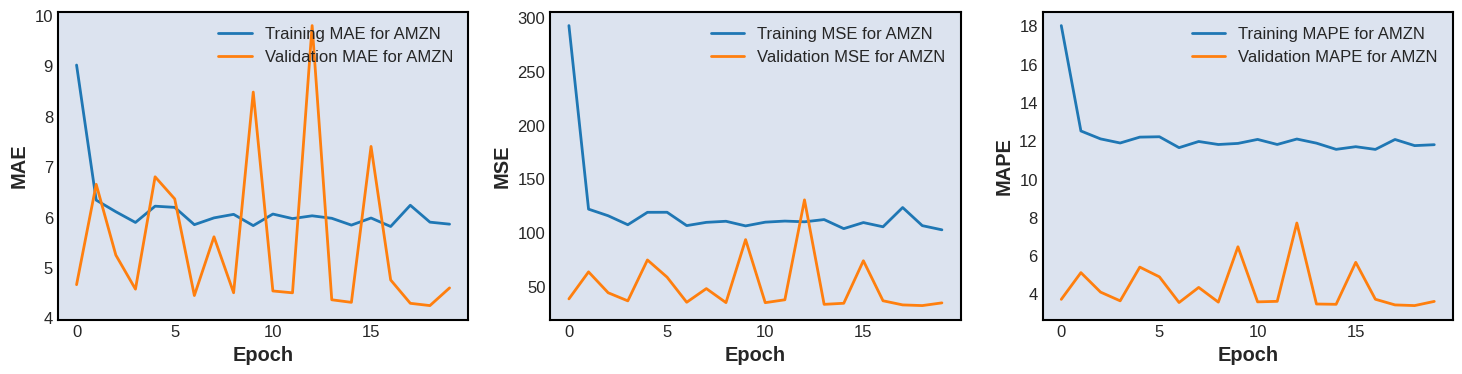

Epoch 1/20
91/91 [==============================] - 0s 2ms/step - loss: 230.2049 - mae: 9.3799 - mse: 230.2049 - mape: 12.0082 - val_loss: 314.4701 - val_mae: 15.7122 - val_mse: 314.4701 - val_mape: 5.2513
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 249.6341 - mae: 9.7053 - mse: 249.6341 - mape: 12.2039 - val_loss: 162.5719 - val_mae: 10.8545 - val_mse: 162.5719 - val_mape: 3.6452
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 223.1858 - mae: 9.2674 - mse: 223.1858 - mape: 11.5657 - val_loss: 130.0515 - val_mae: 9.0085 - val_mse: 130.0515 - val_mape: 3.1699
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 225.4059 - mae: 9.4028 - mse: 225.4059 - mape: 11.8299 - val_loss: 78.2201 - val_mae: 7.3849 - val_mse: 78.2201 - val_mape: 2.5525
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 235.4153 - mae: 9.4778 - mse: 235.4153 - mape: 11.7626 - val_loss: 155.3576 - val_mae: 10.6035 - val_mse: 15

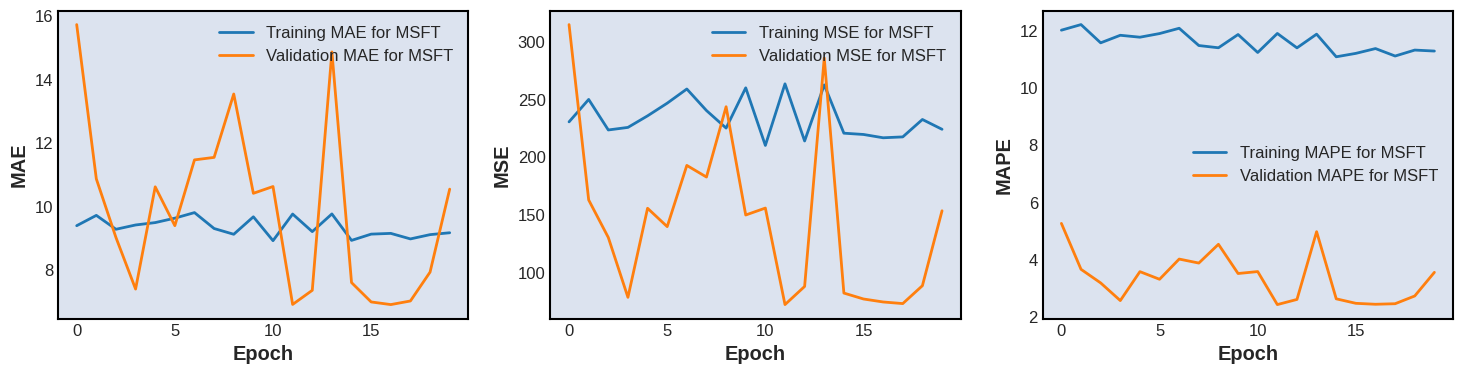

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 50.4072 - mae: 4.3138 - mse: 50.4072 - mape: 10.7595 - val_loss: 37.3475 - val_mae: 5.1990 - val_mse: 37.3475 - val_mape: 3.1908
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 54.6116 - mae: 4.4597 - mse: 54.6116 - mape: 10.8924 - val_loss: 24.5273 - val_mae: 4.1258 - val_mse: 24.5273 - val_mape: 2.5732
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 55.7554 - mae: 4.4644 - mse: 55.7554 - mape: 10.9000 - val_loss: 59.3400 - val_mae: 6.6635 - val_mse: 59.3400 - val_mape: 4.0612
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 55.7549 - mae: 4.5262 - mse: 55.7549 - mape: 10.9806 - val_loss: 26.4678 - val_mae: 4.3311 - val_mse: 26.4678 - val_mape: 2.6848
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 49.1838 - mae: 4.2884 - mse: 49.1838 - mape: 10.4749 - val_loss: 33.3253 - val_mae: 4.9069 - val_mse: 33.3253 - val_mape: 3.

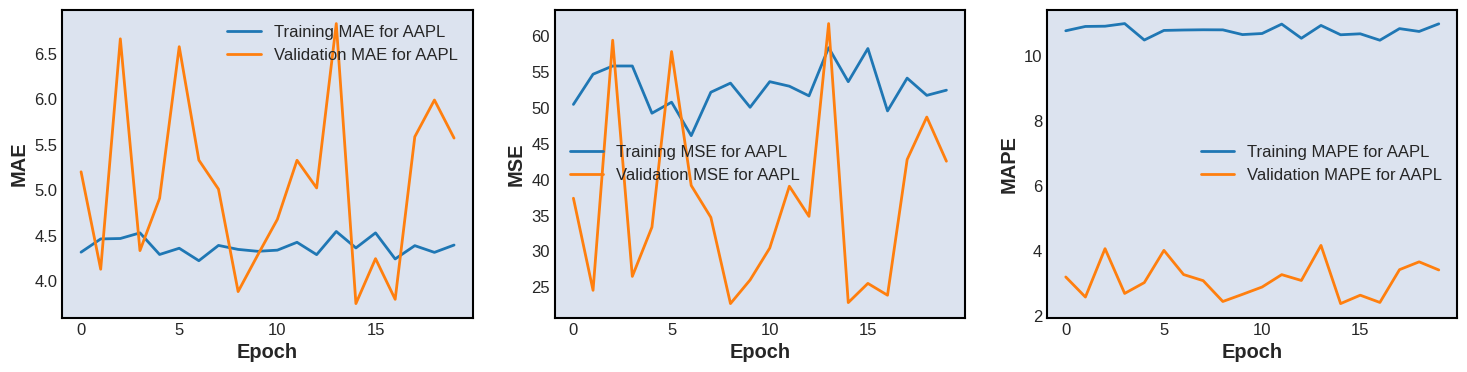

Epoch 1/20
91/91 [==============================] - 0s 2ms/step - loss: 44.9822 - mae: 4.4611 - mse: 44.9822 - mape: 10.6483 - val_loss: 16.1146 - val_mae: 3.2717 - val_mse: 16.1146 - val_mape: 2.7572
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 41.7913 - mae: 4.3046 - mse: 41.7913 - mape: 10.3426 - val_loss: 18.3973 - val_mae: 3.5351 - val_mse: 18.3973 - val_mape: 2.9532
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 47.2435 - mae: 4.5492 - mse: 47.2435 - mape: 10.7488 - val_loss: 14.6259 - val_mae: 3.0053 - val_mse: 14.6259 - val_mape: 2.5799
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 44.6737 - mae: 4.4385 - mse: 44.6737 - mape: 10.7134 - val_loss: 20.0876 - val_mae: 3.4851 - val_mse: 20.0876 - val_mape: 3.0038
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 47.2388 - mae: 4.5527 - mse: 47.2388 - mape: 10.7717 - val_loss: 14.2681 - val_mae: 2.9928 - val_mse: 14.2681 - val_mape: 2.

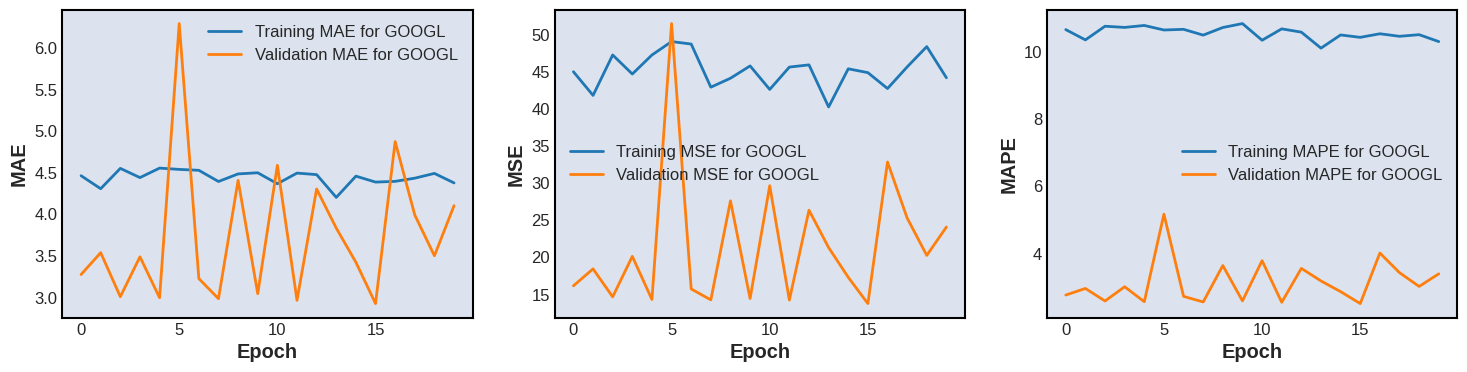

Epoch 1/20
91/91 [==============================] - 0s 3ms/step - loss: 460.5254 - mae: 14.1443 - mse: 460.5254 - mape: 11.9663 - val_loss: 177.1944 - val_mae: 10.2214 - val_mse: 177.1944 - val_mape: 4.6066
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 430.6514 - mae: 13.4129 - mse: 430.6514 - mape: 11.2801 - val_loss: 227.1651 - val_mae: 12.1256 - val_mse: 227.1651 - val_mape: 5.3258
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 428.9849 - mae: 13.4282 - mse: 428.9849 - mape: 11.1647 - val_loss: 147.5267 - val_mae: 8.4944 - val_mse: 147.5267 - val_mape: 4.0357
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 460.6163 - mae: 13.7738 - mse: 460.6163 - mape: 11.3979 - val_loss: 189.4725 - val_mae: 10.7619 - val_mse: 189.4725 - val_mape: 4.8047
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 384.4788 - mae: 12.6785 - mse: 384.4788 - mape: 10.5783 - val_loss: 143.2775 - val_mae: 8.5786 - val_

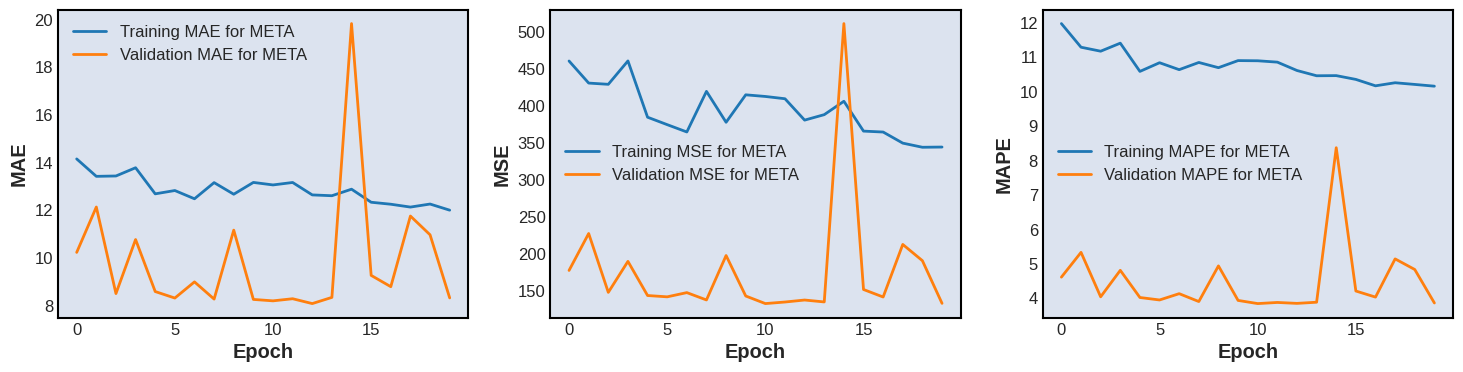

In [61]:
fit_predict(cnn_model, train_test, main_tickers, n_epochs)

Epoch 1/20
 1/91 [..............................] - ETA: 0s - loss: 8.7953 - mae: 2.9534 - mse: 8.7953 - mape: 8061.4370

91/91 [==============================] - 0s 3ms/step - loss: 2.5486 - mae: 1.2027 - mse: 2.5486 - mape: 1083777.8750 - val_loss: 0.0026 - val_mae: 0.0424 - val_mse: 0.0026 - val_mape: 6.1504
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 0.2018 - mae: 0.3559 - mse: 0.2018 - mape: 209033.1562 - val_loss: 0.0059 - val_mae: 0.0672 - val_mse: 0.0059 - val_mape: 10.7598
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1689 - mae: 0.3242 - mse: 0.1689 - mape: 110479.3906 - val_loss: 0.0096 - val_mae: 0.0902 - val_mse: 0.0096 - val_mape: 14.2343
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1503 - mae: 0.3059 - mse: 0.1503 - mape: 221857.3906 - val_loss: 0.0062 - val_mae: 0.0696 - val_mse: 0.0062 - val_mape: 10.9973
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1601 - mae: 0.3147 - mse: 0.1601 - mape: 87291.3906 - val_loss: 0.0186 - val_mae: 0.1311 - val_mse: 0.0186 - val_mape: 20.1056
Ep

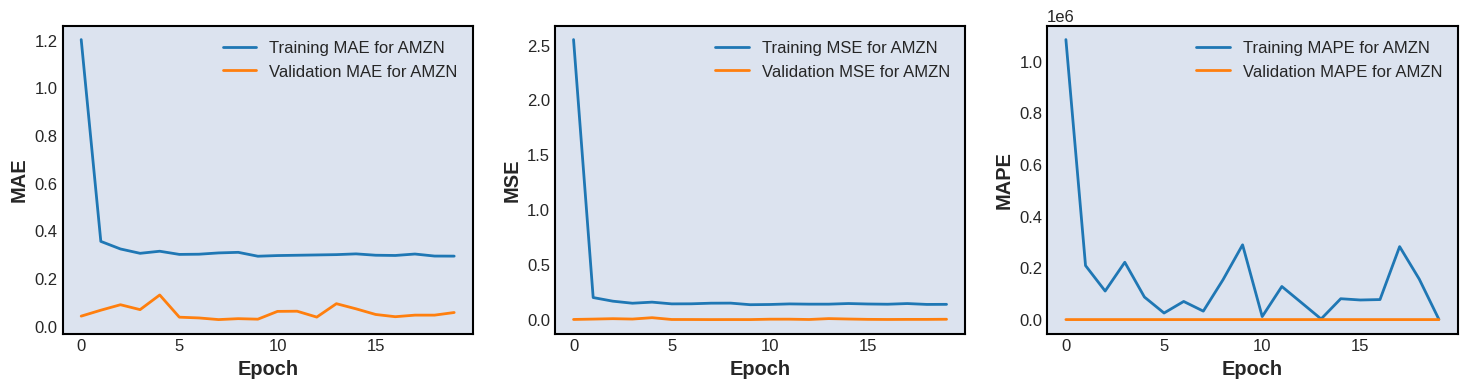

Epoch 1/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1492 - mae: 0.3054 - mse: 0.1492 - mape: 6480.1333 - val_loss: 0.0017 - val_mae: 0.0340 - val_mse: 0.0017 - val_mape: 4.8092
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1468 - mae: 0.3020 - mse: 0.1468 - mape: 164991.0625 - val_loss: 0.0029 - val_mae: 0.0462 - val_mse: 0.0029 - val_mape: 6.5414
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1477 - mae: 0.3046 - mse: 0.1477 - mape: 80644.1875 - val_loss: 9.9055e-04 - val_mae: 0.0255 - val_mse: 9.9055e-04 - val_mape: 3.4189
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1463 - mae: 0.3002 - mse: 0.1463 - mape: 115012.1094 - val_loss: 0.0084 - val_mae: 0.0864 - val_mse: 0.0084 - val_mape: 11.9173
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1525 - mae: 0.3079 - mse: 0.1525 - mape: 12633.5840 - val_loss: 0.0011 - val_mae: 0.0266 - val_mse: 0.0011 - val_map

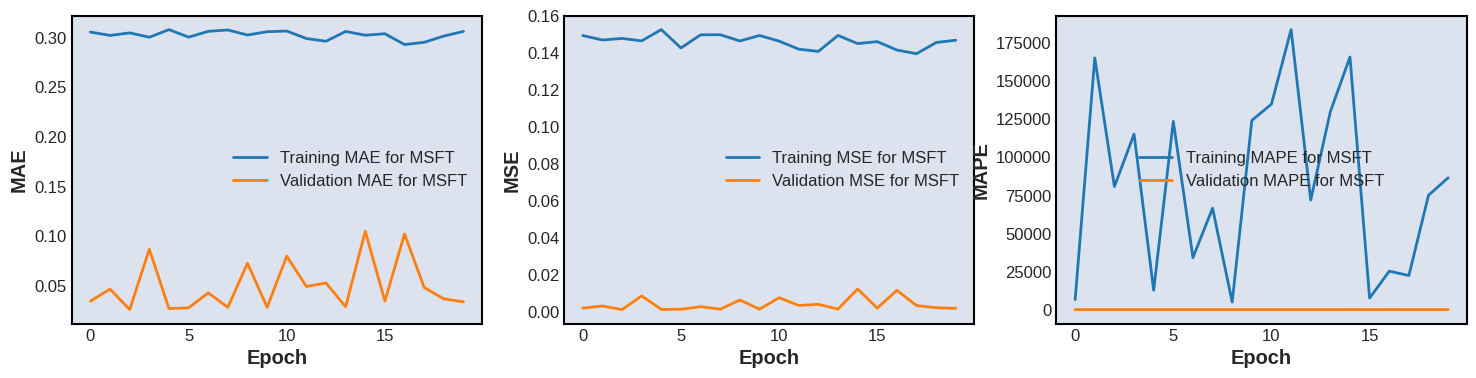

Epoch 1/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1394 - mae: 0.2944 - mse: 0.1394 - mape: 534.2036 - val_loss: 0.0021 - val_mae: 0.0378 - val_mse: 0.0021 - val_mape: 4.9679
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1393 - mae: 0.2974 - mse: 0.1393 - mape: 564.9320 - val_loss: 0.0023 - val_mae: 0.0394 - val_mse: 0.0023 - val_mape: 5.1900
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1375 - mae: 0.2901 - mse: 0.1375 - mape: 505.3097 - val_loss: 0.0012 - val_mae: 0.0285 - val_mse: 0.0012 - val_mape: 3.4609
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1388 - mae: 0.2959 - mse: 0.1388 - mape: 551.3875 - val_loss: 0.0051 - val_mae: 0.0632 - val_mse: 0.0051 - val_mape: 8.2323
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1345 - mae: 0.2874 - mse: 0.1345 - mape: 522.7224 - val_loss: 0.0066 - val_mae: 0.0749 - val_mse: 0.0066 - val_mape: 9.6263
Epoch 6/20

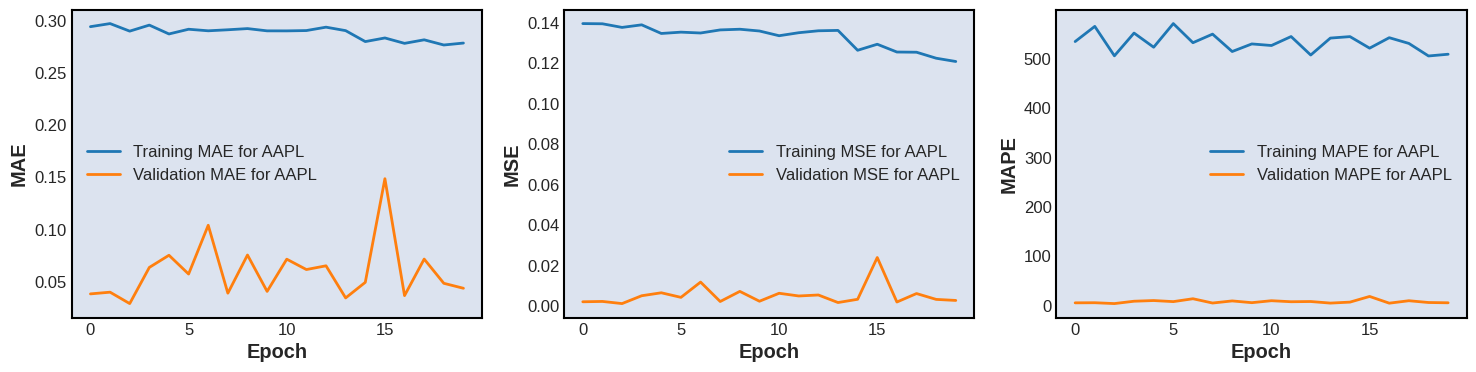

Epoch 1/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1249 - mae: 0.2781 - mse: 0.1249 - mape: 101527.6172 - val_loss: 0.0016 - val_mae: 0.0337 - val_mse: 0.0016 - val_mape: 4.3563
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1155 - mae: 0.2685 - mse: 0.1155 - mape: 27338.4883 - val_loss: 0.0081 - val_mae: 0.0807 - val_mse: 0.0081 - val_mape: 9.8639
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1225 - mae: 0.2796 - mse: 0.1225 - mape: 62607.7148 - val_loss: 0.0020 - val_mae: 0.0365 - val_mse: 0.0020 - val_mape: 4.9328
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1186 - mae: 0.2713 - mse: 0.1186 - mape: 64498.0039 - val_loss: 0.0116 - val_mae: 0.1027 - val_mse: 0.0116 - val_mape: 13.7255
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1184 - mae: 0.2724 - mse: 0.1184 - mape: 3995.7310 - val_loss: 0.0041 - val_mae: 0.0562 - val_mse: 0.0041 - val_mape: 7.5572

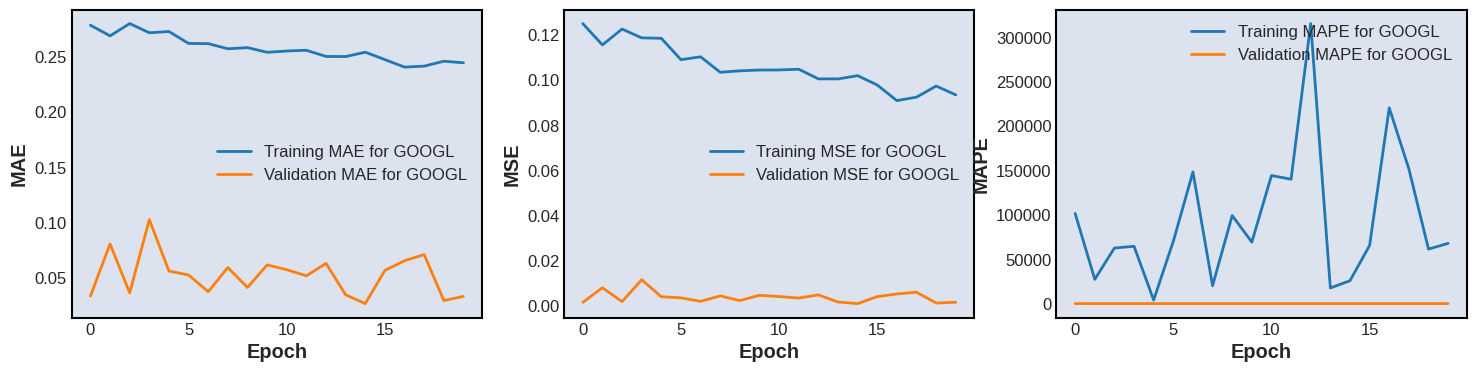

Epoch 1/20
91/91 [==============================] - 0s 2ms/step - loss: 0.0853 - mae: 0.2308 - mse: 0.0853 - mape: 121038.7031 - val_loss: 0.0049 - val_mae: 0.0612 - val_mse: 0.0049 - val_mape: 11.2637
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 0.0823 - mae: 0.2267 - mse: 0.0823 - mape: 158186.4062 - val_loss: 0.0030 - val_mae: 0.0448 - val_mse: 0.0030 - val_mape: 10.1659
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 0.0775 - mae: 0.2200 - mse: 0.0775 - mape: 45334.5312 - val_loss: 0.0031 - val_mae: 0.0457 - val_mse: 0.0031 - val_mape: 9.8623
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 0.0795 - mae: 0.2241 - mse: 0.0795 - mape: 149400.9844 - val_loss: 0.0017 - val_mae: 0.0325 - val_mse: 0.0017 - val_mape: 5.8662
Epoch 5/20
91/91 [==============================] - 0s 2ms/step - loss: 0.0769 - mae: 0.2180 - mse: 0.0769 - mape: 12330.8633 - val_loss: 0.0066 - val_mae: 0.0724 - val_mse: 0.0066 - val_mape: 15

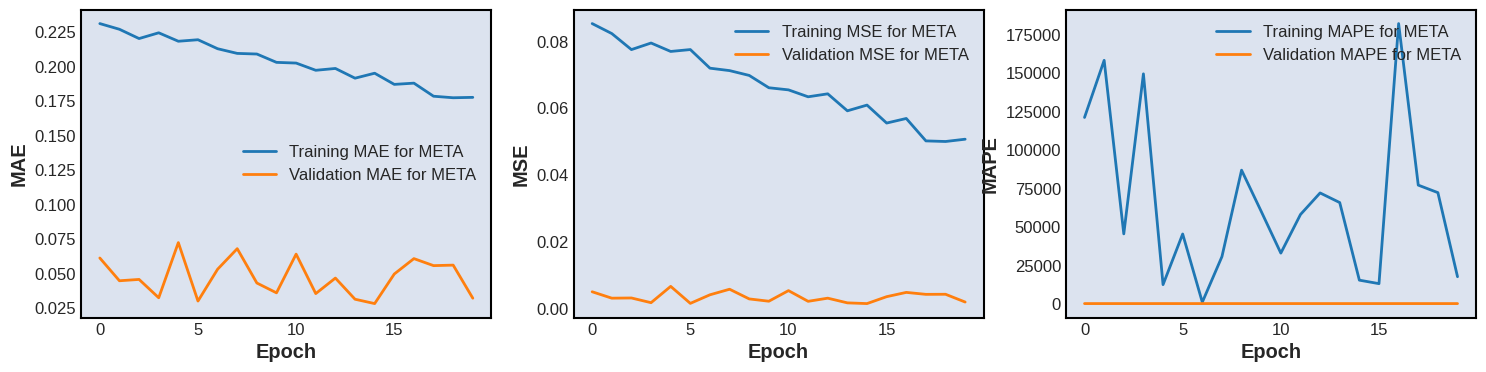

In [62]:
fit_predict(cnn_model, train_test_scaled, main_tickers, n_epochs)

### Conv-LSTM

In [63]:
conv_lstm_model = Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(50, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])


conv_lstm_model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae'),
                       tf.keras.metrics.MeanSquaredError(name='mse'),
                       tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])

conv_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 8, 64)             256       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 50)                23000     
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                      

Epoch 1/20
91/91 [==============================] - 2s 8ms/step - loss: 638.4218 - mae: 12.8345 - mse: 638.4218 - mape: 26.3506 - val_loss: 54.1709 - val_mae: 6.0290 - val_mse: 54.1709 - val_mape: 4.6484
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 110.8713 - mae: 5.9630 - mse: 110.8713 - mape: 12.0215 - val_loss: 47.9509 - val_mae: 5.2584 - val_mse: 47.9509 - val_mape: 4.1721
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 77.5081 - mae: 5.0267 - mse: 77.5081 - mape: 10.1638 - val_loss: 47.3735 - val_mae: 5.1414 - val_mse: 47.3735 - val_mape: 4.0943
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 79.0975 - mae: 5.0871 - mse: 79.0975 - mape: 10.1228 - val_loss: 72.7991 - val_mae: 7.0165 - val_mse: 72.7991 - val_mape: 5.4123
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 82.0798 - mae: 5.1645 - mse: 82.0798 - mape: 10.1113 - val_loss: 41.3959 - val_mae: 4.9710 - val_mse: 41.3959 - val_map

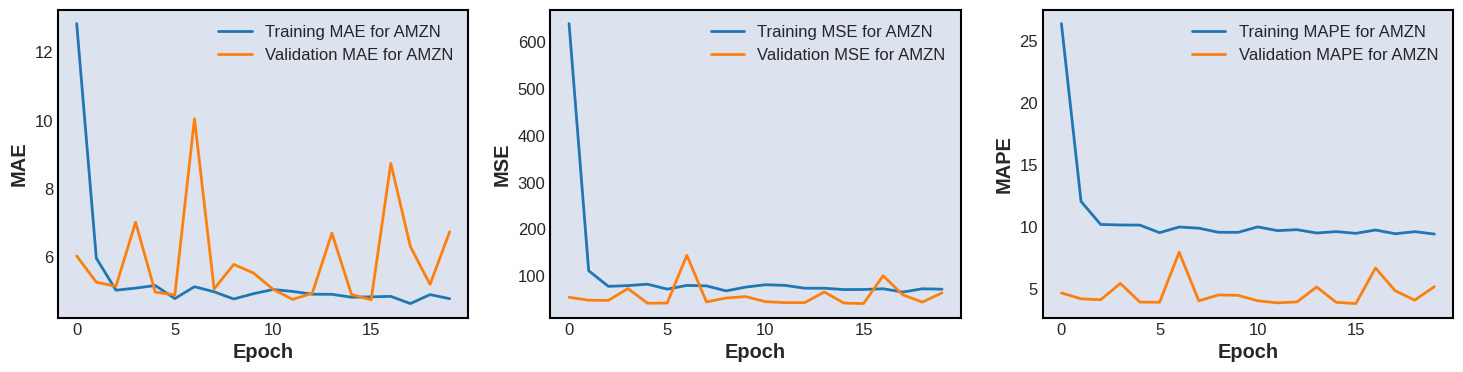

Epoch 1/20
91/91 [==============================] - 1s 6ms/step - loss: 159.5537 - mae: 7.7724 - mse: 159.5537 - mape: 9.7971 - val_loss: 95.8399 - val_mae: 7.8807 - val_mse: 95.8399 - val_mape: 2.7658
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 172.4892 - mae: 8.0555 - mse: 172.4892 - mape: 9.9816 - val_loss: 131.7055 - val_mae: 9.7355 - val_mse: 131.7055 - val_mape: 3.2983
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 155.4395 - mae: 7.4698 - mse: 155.4395 - mape: 9.2381 - val_loss: 107.5200 - val_mae: 8.1938 - val_mse: 107.5200 - val_mape: 2.8873
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 161.3445 - mae: 7.8204 - mse: 161.3445 - mape: 9.7292 - val_loss: 392.0171 - val_mae: 17.4617 - val_mse: 392.0171 - val_mape: 5.8240
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 159.0747 - mae: 7.8142 - mse: 159.0747 - mape: 9.7899 - val_loss: 509.8048 - val_mae: 20.3428 - val_mse: 509.8048

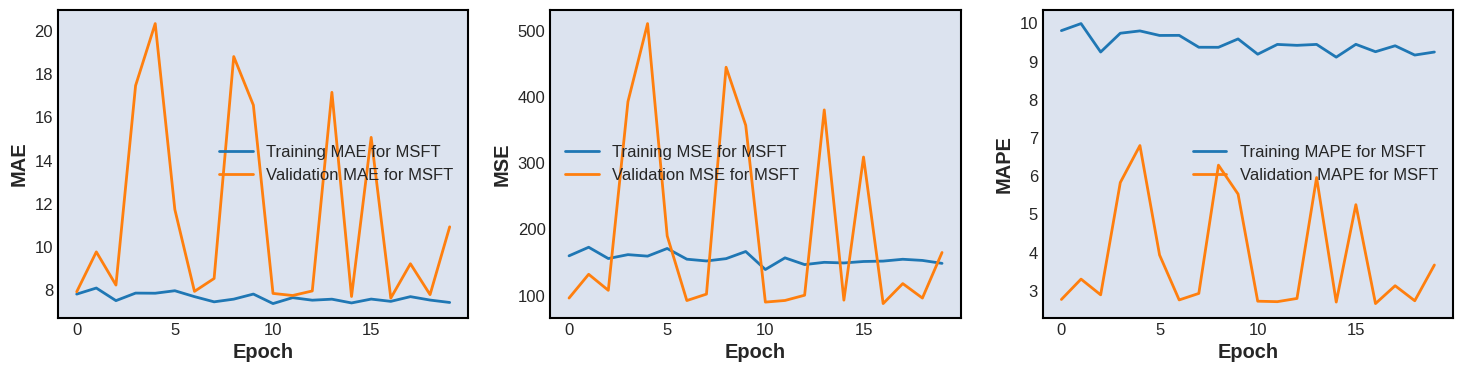

Epoch 1/20
91/91 [==============================] - 1s 7ms/step - loss: 37.2172 - mae: 3.6251 - mse: 37.2172 - mape: 8.8580 - val_loss: 27.0617 - val_mae: 4.2244 - val_mse: 27.0617 - val_mape: 2.6594
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 35.7152 - mae: 3.5851 - mse: 35.7152 - mape: 8.9446 - val_loss: 26.6272 - val_mae: 4.2282 - val_mse: 26.6272 - val_mape: 2.6559
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 36.0211 - mae: 3.6076 - mse: 36.0211 - mape: 8.9506 - val_loss: 53.6183 - val_mae: 6.2479 - val_mse: 53.6183 - val_mape: 3.8139
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 36.2069 - mae: 3.6389 - mse: 36.2069 - mape: 8.8507 - val_loss: 28.6481 - val_mae: 4.1997 - val_mse: 28.6481 - val_mape: 2.6646
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 34.2411 - mae: 3.5920 - mse: 34.2411 - mape: 9.0644 - val_loss: 25.8313 - val_mae: 4.1112 - val_mse: 25.8313 - val_mape: 2.5891


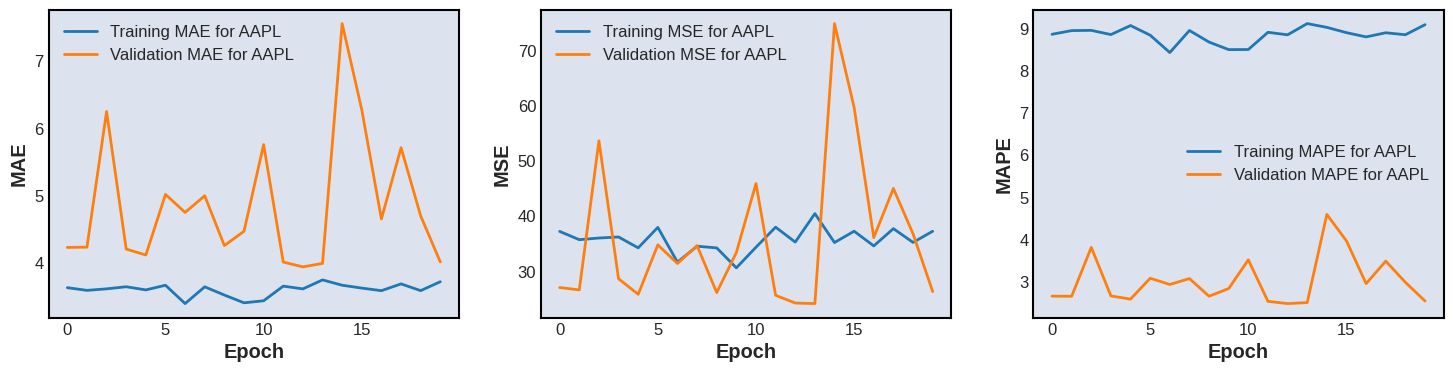

Epoch 1/20
91/91 [==============================] - 1s 6ms/step - loss: 28.8686 - mae: 3.5955 - mse: 28.8686 - mape: 8.6452 - val_loss: 60.8614 - val_mae: 6.8754 - val_mse: 60.8614 - val_mape: 5.6282
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 28.2996 - mae: 3.6114 - mse: 28.2996 - mape: 8.7803 - val_loss: 15.2917 - val_mae: 3.1121 - val_mse: 15.2917 - val_mape: 2.6605
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 29.0087 - mae: 3.6341 - mse: 29.0087 - mape: 8.7807 - val_loss: 23.5630 - val_mae: 4.0360 - val_mse: 23.5630 - val_mape: 3.3437
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 28.0045 - mae: 3.5297 - mse: 28.0045 - mape: 8.5330 - val_loss: 18.0809 - val_mae: 3.5034 - val_mse: 18.0809 - val_mape: 2.9391
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 32.8765 - mae: 3.7071 - mse: 32.8765 - mape: 8.8841 - val_loss: 15.8064 - val_mae: 3.1083 - val_mse: 15.8064 - val_mape: 2.6762


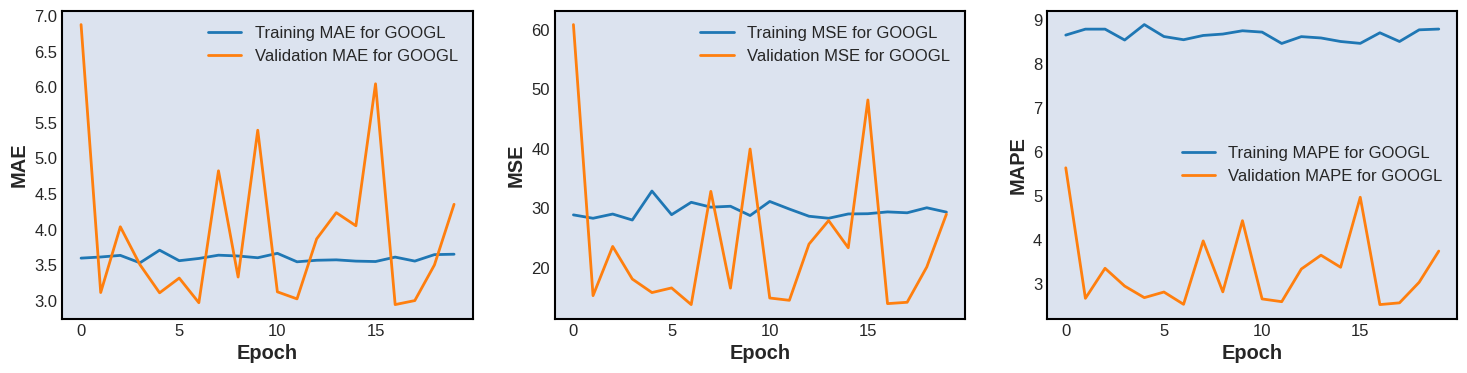

Epoch 1/20
91/91 [==============================] - 1s 6ms/step - loss: 313.3477 - mae: 11.4601 - mse: 313.3477 - mape: 9.8147 - val_loss: 141.5020 - val_mae: 8.8428 - val_mse: 141.5020 - val_mape: 4.0748
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 286.2138 - mae: 11.0147 - mse: 286.2138 - mape: 9.2558 - val_loss: 129.2328 - val_mae: 8.0098 - val_mse: 129.2328 - val_mape: 3.8080
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 301.5865 - mae: 11.0913 - mse: 301.5865 - mape: 9.2831 - val_loss: 129.2251 - val_mae: 8.0834 - val_mse: 129.2251 - val_mape: 3.8081
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 286.1471 - mae: 11.0306 - mse: 286.1471 - mape: 9.1847 - val_loss: 184.5296 - val_mae: 9.5333 - val_mse: 184.5296 - val_mape: 4.5231
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 272.2642 - mae: 10.8521 - mse: 272.2642 - mape: 9.2777 - val_loss: 150.6934 - val_mae: 9.4542 - val_mse: 150

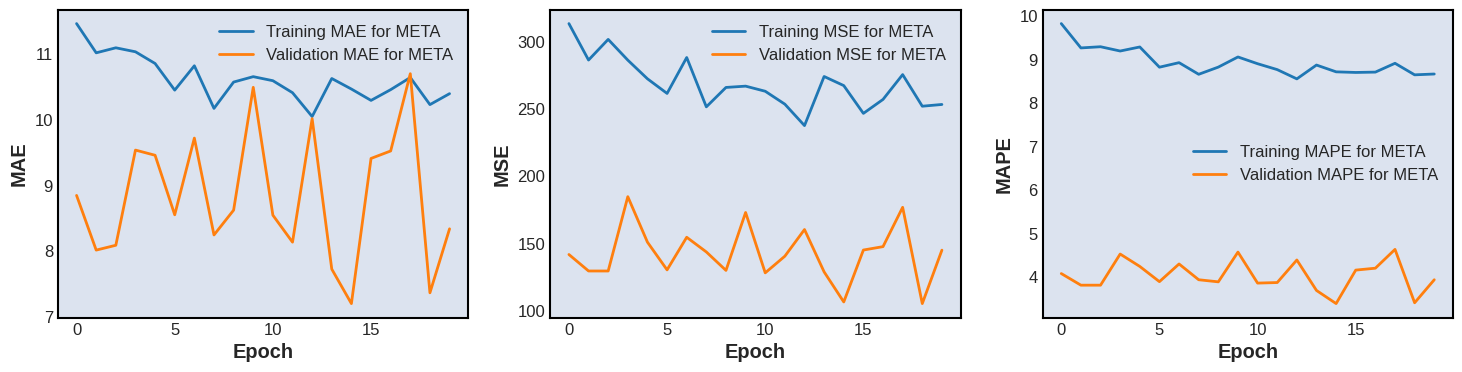

In [64]:
fit_predict(conv_lstm_model, train_test, main_tickers, n_epochs)

Epoch 1/20
 1/91 [..............................] - ETA: 0s - loss: 4.7221 - mae: 2.1567 - mse: 4.7221 - mape: 5130.3403

91/91 [==============================] - 1s 7ms/step - loss: 0.7222 - mae: 0.5764 - mse: 0.7222 - mape: 84091.7812 - val_loss: 0.0027 - val_mae: 0.0431 - val_mse: 0.0027 - val_mape: 6.9661
Epoch 2/20
91/91 [==============================] - 1s 7ms/step - loss: 0.1119 - mae: 0.2669 - mse: 0.1119 - mape: 4184.7358 - val_loss: 0.0017 - val_mae: 0.0322 - val_mse: 0.0017 - val_mape: 5.0950
Epoch 3/20
91/91 [==============================] - 1s 7ms/step - loss: 0.1044 - mae: 0.2518 - mse: 0.1044 - mape: 112841.3047 - val_loss: 0.0024 - val_mae: 0.0409 - val_mse: 0.0024 - val_mape: 6.3500
Epoch 4/20
91/91 [==============================] - 1s 7ms/step - loss: 0.0976 - mae: 0.2419 - mse: 0.0976 - mape: 4855.1367 - val_loss: 0.0052 - val_mae: 0.0647 - val_mse: 0.0052 - val_mape: 10.2798
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0969 - mae: 0.2411 - mse: 0.0969 - mape: 116790.1250 - val_loss: 0.0115 - val_mae: 0.1022 - val_mse: 0.0115 - val_mape: 16.0140
Epoch 6/2

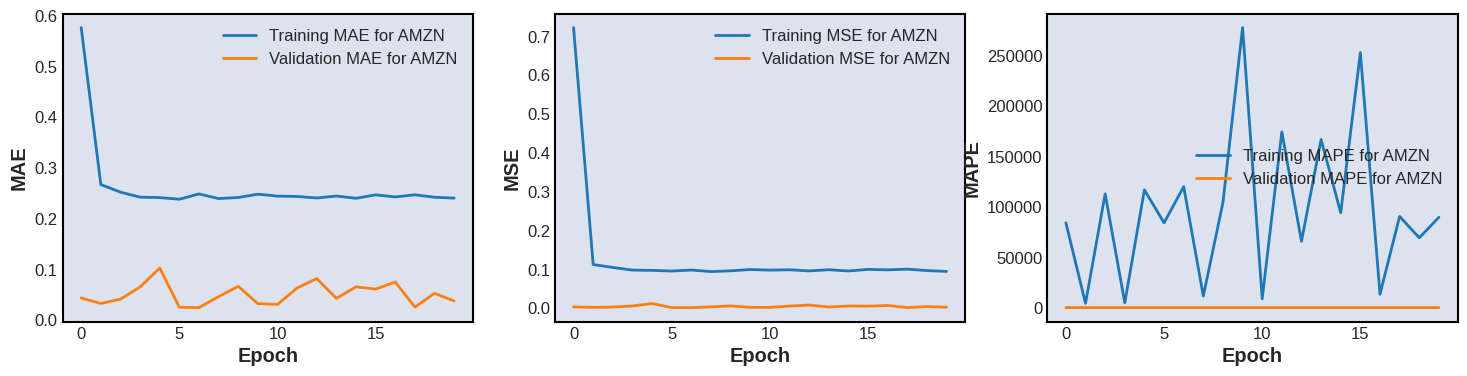

Epoch 1/20
91/91 [==============================] - 1s 6ms/step - loss: 0.1027 - mae: 0.2502 - mse: 0.1027 - mape: 99947.1016 - val_loss: 9.0584e-04 - val_mae: 0.0236 - val_mse: 9.0584e-04 - val_mape: 3.3391
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0980 - mae: 0.2433 - mse: 0.0980 - mape: 85781.1562 - val_loss: 0.0052 - val_mae: 0.0675 - val_mse: 0.0052 - val_mape: 9.4252
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 0.1042 - mae: 0.2515 - mse: 0.1042 - mape: 102285.4531 - val_loss: 7.0577e-04 - val_mae: 0.0212 - val_mse: 7.0577e-04 - val_mape: 2.9583
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0988 - mae: 0.2485 - mse: 0.0988 - mape: 76551.2734 - val_loss: 7.3295e-04 - val_mae: 0.0225 - val_mse: 7.3295e-04 - val_mape: 2.9900
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0980 - mae: 0.2456 - mse: 0.0980 - mape: 142681.5469 - val_loss: 9.8628e-04 - val_mae: 0.0265 - val_m

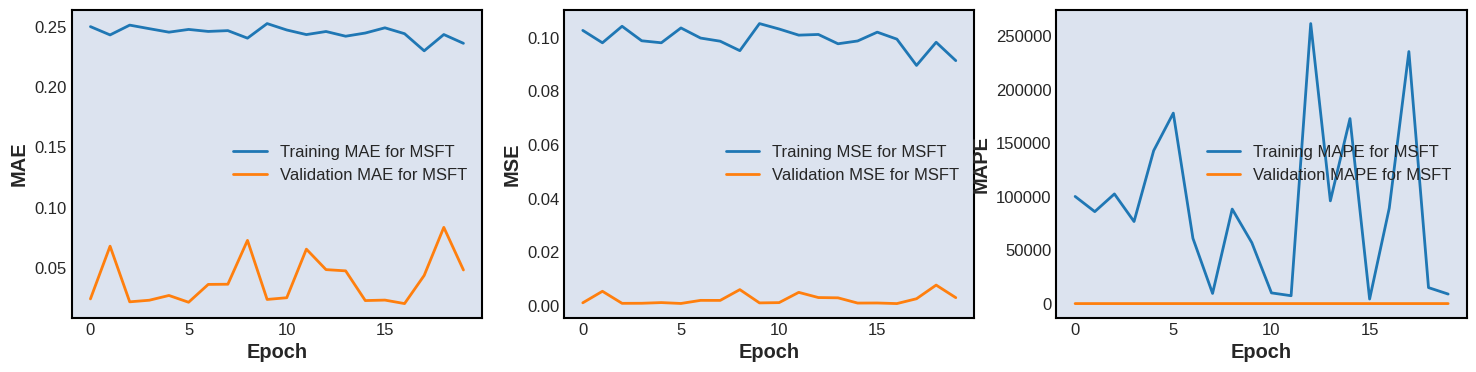

Epoch 1/20
91/91 [==============================] - 1s 7ms/step - loss: 0.0948 - mae: 0.2404 - mse: 0.0948 - mape: 434.2013 - val_loss: 9.5933e-04 - val_mae: 0.0242 - val_mse: 9.5933e-04 - val_mape: 3.1136
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0906 - mae: 0.2321 - mse: 0.0906 - mape: 446.5782 - val_loss: 0.0018 - val_mae: 0.0354 - val_mse: 0.0018 - val_mape: 4.5471
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0882 - mae: 0.2285 - mse: 0.0882 - mape: 427.5563 - val_loss: 0.0018 - val_mae: 0.0346 - val_mse: 0.0018 - val_mape: 4.4455
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0929 - mae: 0.2386 - mse: 0.0929 - mape: 448.2031 - val_loss: 6.7641e-04 - val_mae: 0.0217 - val_mse: 6.7641e-04 - val_mape: 2.6829
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0886 - mae: 0.2316 - mse: 0.0886 - mape: 432.3908 - val_loss: 6.5440e-04 - val_mae: 0.0212 - val_mse: 6.5440e-04 - val

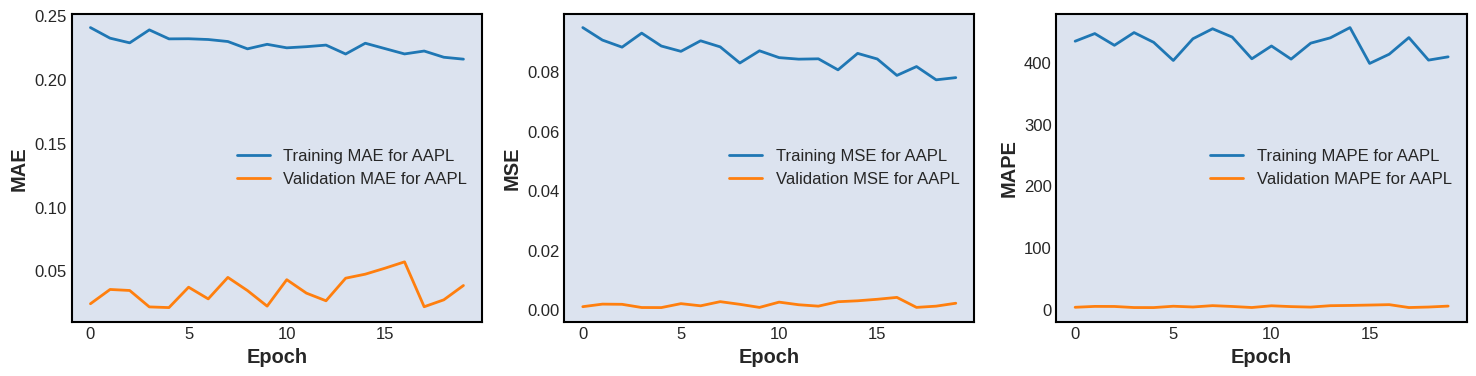

Epoch 1/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0698 - mae: 0.2063 - mse: 0.0698 - mape: 55886.4414 - val_loss: 0.0015 - val_mae: 0.0319 - val_mse: 0.0015 - val_mape: 4.3469
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0733 - mae: 0.2110 - mse: 0.0733 - mape: 97348.5000 - val_loss: 0.0026 - val_mae: 0.0409 - val_mse: 0.0026 - val_mape: 5.7786
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0707 - mae: 0.2030 - mse: 0.0707 - mape: 147490.7812 - val_loss: 0.0013 - val_mae: 0.0299 - val_mse: 0.0013 - val_mape: 4.0548
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0674 - mae: 0.1975 - mse: 0.0674 - mape: 1258.6373 - val_loss: 0.0011 - val_mae: 0.0266 - val_mse: 0.0011 - val_mape: 3.6168
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0662 - mae: 0.1973 - mse: 0.0662 - mape: 4046.5791 - val_loss: 0.0029 - val_mae: 0.0461 - val_mse: 0.0029 - val_mape: 6.2141
E

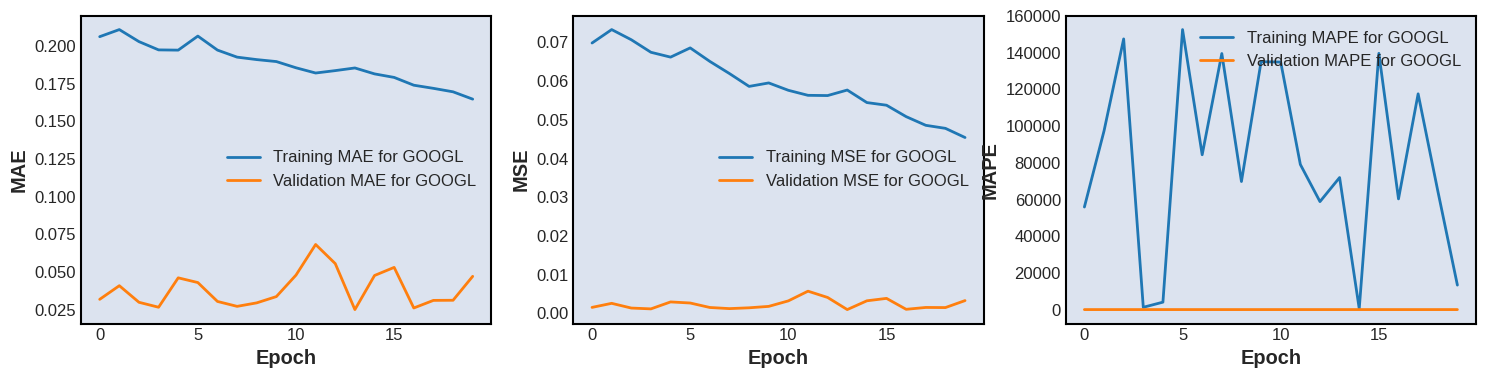

Epoch 1/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0405 - mae: 0.1545 - mse: 0.0405 - mape: 105273.0078 - val_loss: 0.0022 - val_mae: 0.0353 - val_mse: 0.0022 - val_mape: 7.1927
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0400 - mae: 0.1534 - mse: 0.0400 - mape: 52856.8203 - val_loss: 0.0012 - val_mae: 0.0260 - val_mse: 0.0012 - val_mape: 5.0667
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0402 - mae: 0.1538 - mse: 0.0402 - mape: 8839.3428 - val_loss: 0.0018 - val_mae: 0.0319 - val_mse: 0.0018 - val_mape: 6.5175
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0378 - mae: 0.1505 - mse: 0.0378 - mape: 292006.3438 - val_loss: 0.0013 - val_mae: 0.0268 - val_mse: 0.0013 - val_mape: 5.3585
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 0.0361 - mae: 0.1482 - mse: 0.0361 - mape: 54508.3398 - val_loss: 0.0015 - val_mae: 0.0280 - val_mse: 0.0015 - val_mape: 5.7454

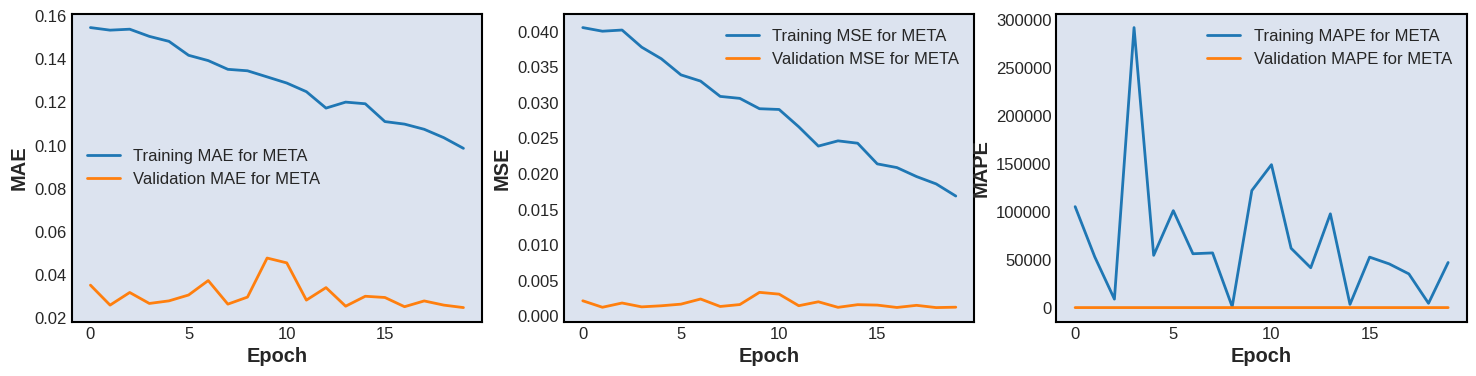

In [65]:
fit_predict(conv_lstm_model, train_test_scaled, main_tickers, n_epochs)

## Naive Forecast

In [79]:
def naive_forecast(data):
    for column in data.columns:
        pred_data = data[column].shift(-1).ffill()

        mse = mean_squared_error(pred_data, data[column])
        mae = mean_absolute_error(pred_data, data[column])
        mape = mean_absolute_percentage_error(pred_data, data[column])
        
        print(f'MSE for {column[0]} using naive forecast: {mse}')
        print(f'MAE for {column[0]} using naive forecast: {mae}')
        print(f'MAPE for {column[0]} using naive forecast: {mape}')
        print('----------------------------------------------------')

In [80]:
naive_forecast(close_price)

MSE for AMZN using naive forecast: 3.194786983888704
MAE for AMZN using naive forecast: 0.9490935384990005
MAPE for AMZN using naive forecast: 0.014491755690516757
----------------------------------------------------
MSE for MSFT using naive forecast: 7.316379492316035
MAE for MSFT using naive forecast: 1.435687919039832
MAPE for MSFT using naive forecast: 0.011368661847006807
----------------------------------------------------
MSE for AAPL using naive forecast: 2.170306405159665
MAE for AAPL using naive forecast: 0.7866549884954456
MAPE for AAPL using naive forecast: 0.012578329312974344
----------------------------------------------------
MSE for GOOGL using naive forecast: 1.5359183513736006
MAE for GOOGL using naive forecast: 0.6852197779925998
MAPE for GOOGL using naive forecast: 0.011763809531760382
----------------------------------------------------
MSE for META using naive forecast: 15.365704507596117
MAE for META using naive forecast: 2.0514041690273404
MAPE for META using n